In [4]:
# Ensemble Variant 1: S: Densenet201, W: ResNet152d (Batch_size = 32)
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.metrics import roc_curve, auc
from tqdm import tqdm
import sys
sys.path.extend(["..", "../../backbone","../.."])
from densenet201 import DenseNet201
from resnet152d import ResNet152d
from dataloader import create_dataloader
from metric import Metric
from ctran import CTranEncoder
torch.cuda.empty_cache()
from sklearn.metrics import precision_recall_curve, roc_auc_score, f1_score
from tabulate import tabulate
# from torchsummary import summary

# Set device to GPU if available, else use CPU
device = torch.device("cuda")
print(f"Current device: {torch.cuda.get_device_name(torch.cuda.current_device())}" if torch.cuda.is_available() else "Current device: CPU")

Current device: NVIDIA RTX A6000


In [2]:
# Define hyperparameters
batch_size = 32
num_epochs = 200
learning_rate = 0.000001
image_size = 384
num_workers = 8
num_layers = 12
embed_dim = 960
num_labels = 20
thresholds = [0.5] * num_labels
num_classes = 20
data_dir = '../../../mured-data/data'

In [3]:
# Create dataloaders
train_dataloader = create_dataloader(data_dir=data_dir, batch_size=batch_size, num_workers=num_workers, size=image_size, phase='train')
val_dataloader = create_dataloader(data_dir=data_dir, batch_size=batch_size, num_workers=num_workers, size=image_size, phase='val')

384
384


In [4]:
# Define model and optimizer
backbone1 = ResNet152d(num_classes=num_classes, embed_dim = embed_dim)
model1 = CTranEncoder(num_classes=num_classes, embed_dim=embed_dim, num_layers=num_layers, num_heads=num_workers, backbone=backbone1)
model1.to(device)

# Define model and optimizer
backbone2 = DenseNet201(num_classes=num_classes, embed_dim = embed_dim)
model2 = CTranEncoder(num_classes=num_classes, embed_dim=embed_dim, num_layers=num_layers, num_heads=num_workers, backbone=backbone2)
model2.to(device)

# Wrap your model with DataParallel
# model1 = nn.DataParallel(model1, device_ids=[0, 1, 2, 3])
# model2 = nn.DataParallel(model2, device_ids=[0, 1, 2, 3])

criterion = nn.BCEWithLogitsLoss()

# Define your optimizers
# Combine the parameters of both models
params = list(model1.parameters()) + list(model2.parameters())

# Create a single optimizer
optimizer = torch.optim.AdamW(params, lr=5e-5, weight_decay=1e-6)

# Create a single scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)
#scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-3, epochs= num_epochs, steps_per_epoch=len(train_dataloader))

/home/deependra/project/rfmidc/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/deependra/project/rfmidc/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
# Initialize Metric class
metric1 = Metric(num_classes=num_classes)
metric2 = Metric(num_classes=num_classes)

# create empty lists to store predicted probabilities and true labels for each epoch
val_preds_all, val_labels_all = [], []

# define the epochs at which to plot the ROC curve
roc_epochs = [5,10,20,30,40,50,60,70,80,90,100,120,140,160,180,200]

# create empty lists to store ROC data for each epoch
roc_fpr = []
roc_tpr = []
roc_auc = []
f1_arr = []
loss_arr = []
model_arr = []
max_ms = [0,0,0]
a,b = 0.4,0.6

# Train and evaluate model
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    print('-' * 10)

    # Train phase
    model1.train()
    model2.train()
    for images, labels in tqdm(train_dataloader):
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs1 = model1(images)
        loss1 = criterion(outputs1, labels) 
        outputs1 = torch.sigmoid(outputs1)
           
    
        # Forward pass for model2
        outputs2 = model2(images)
        loss2 = criterion(outputs2, labels)
        outputs2 = torch.sigmoid(outputs2)
         
        
        # Calculate weighted average loss
        loss = a * loss1 + b * loss2
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Compute metrics on train set
        with torch.no_grad():
            metric1.update(outputs1, labels,0)
            
        with torch.no_grad():
            metric2.update(outputs2, labels,0)
    
    # Print metrics on train set 1
    ml_f1_score, map_score, auc_score, ml_map_score, ml_auc_score, ml_score, bin_auc, model_score, bin_f1_score = metric2.compute(1)
    print("DenseNet201:\n",f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, ML mAP: {ml_map_score:.4f}, ML F1: {ml_f1_score:.4f}, ML AUC: {ml_auc_score:.4f}, ML Score: {ml_score:.4f}, Bin AUC: {bin_auc:.4f}, Model Score: {model_score:.4f}, Bin F1: {bin_f1_score:.4f}")
    
    # Print metrics on train set 2
    ml_f1_score, map_score, auc_score, ml_map_score, ml_auc_score, ml_score, bin_auc, model_score, bin_f1_score = metric1.compute(1)
    print("ResNet152d:\n",f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, ML mAP: {ml_map_score:.4f}, ML F1: {ml_f1_score:.4f}, ML AUC: {ml_auc_score:.4f}, ML Score: {ml_score:.4f}, Bin AUC: {bin_auc:.4f}, Model Score: {model_score:.4f}, Bin F1: {bin_f1_score:.4f}")
    
    # Reset Metric class for evaluation
    metric1.reset()
    metric2.reset()
    del images
    del labels
    del outputs1
    del outputs2
    torch.cuda.empty_cache() 

    # Evaluate model on validation set
    model1.eval()
    model2.eval()
    running_loss = 0.0
    val_preds, val_labels = [], []
    with torch.no_grad():
        for images, labels in tqdm(val_dataloader):
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs1 = model1(images)
            loss1 = criterion(outputs1, labels) 
            outputs1 = torch.sigmoid(outputs1)
               
    
            # Forward pass for model2
            outputs2 = model2(images)
            loss2 = criterion(outputs2, labels) 
            outputs2 = torch.sigmoid(outputs2)
            
        
            # Calculate weighted average loss
            loss = a * loss1 + b * loss2
            running_loss += loss.item()
            
            # Perform weighted average of model predictions
            weighted_outputs = a * outputs1 + b * outputs2

            # append the predicted probabilities and true labels to lists for calculating ROC AUC score later
            val_preds += weighted_outputs.tolist()
            val_labels += labels.tolist()
            metric1.update(weighted_outputs, labels,1)

 
        # Print metrics on validation set
        ml_f1_score, map_score, auc_score, ml_map_score, ml_auc_score, ml_score, bin_auc, model_score, bin_f1_score = metric1.compute(0)
        print(f"Val - Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, ML mAP: {ml_map_score:.4f}, ML F1: {ml_f1_score:.4f}, ML AUC: {ml_auc_score:.4f}, ML Score: {ml_score:.4f}, Bin AUC: {bin_auc:.4f}, Model Score: {model_score:.4f}, Bin F1: {bin_f1_score:.4f}")
        
        f1_arr.append(ml_f1_score)
        model_arr.append(model_score)
        loss_arr.append(running_loss / len(val_dataloader))
        
        if max_ms[0] < model_score: 
            max_ms[0] = model_score
            max_ms[1] = epoch
            max_ms[2] = optimizer.param_groups[0]['lr']

        # append the predicted probabilities and true labels for this epoch to the lists for all epochs
        val_preds_all.append(val_preds)
        val_labels_all.append(val_labels)

        # check if the current epoch is in the list of epochs to plot ROC curve
        if epoch+1 in roc_epochs:
            # calculate ROC curve and AUC score for validation set
            fpr, tpr, roc_thresholds = roc_curve(np.concatenate(val_labels_all).ravel(), np.concatenate(val_preds_all).ravel())
            roc_fpr.append(fpr)
            roc_tpr.append(tpr)
            roc_auc.append(auc(fpr, tpr))

        print() # empty line for spacing    
        
        # Reset Metric class for next epoch
        metric1.reset()
        del images
        del labels
        del outputs1
        del outputs2
        torch.cuda.empty_cache()   
    
    # Step the learning rate scheduler
    scheduler.step()     

Epoch 1/200
----------


100%|██████████| 56/56 [00:51<00:00,  1.09it/s]


DenseNet201:
 Epoch [1/200], Loss: 0.2985, ML mAP: 0.1360, ML F1: 0.0204, ML AUC: 0.6655, ML Score: 0.4008, Bin AUC: 0.3725, Model Score: 0.3867, Bin F1: 0.1818
ResNet152d:
 Epoch [1/200], Loss: 0.2985, ML mAP: 0.0796, ML F1: 0.0150, ML AUC: 0.5008, ML Score: 0.2902, Bin AUC: 0.6667, Model Score: 0.4784, Bin F1: 0.4286


100%|██████████| 14/14 [00:06<00:00,  2.30it/s]


Val - Epoch [1/200], Loss: 0.2546, ML mAP: 0.2341, ML F1: 0.0000, ML AUC: 0.8038, ML Score: 0.5189, Bin AUC: 0.1579, Model Score: 0.3384, Bin F1: 0.0000

Epoch 2/200
----------


100%|██████████| 56/56 [00:49<00:00,  1.13it/s]


DenseNet201:
 Epoch [2/200], Loss: 0.2041, ML mAP: 0.2320, ML F1: 0.0378, ML AUC: 0.7887, ML Score: 0.5104, Bin AUC: 1.0000, Model Score: 0.7552, Bin F1: 0.0000
ResNet152d:
 Epoch [2/200], Loss: 0.2041, ML mAP: 0.0785, ML F1: 0.0000, ML AUC: 0.4873, ML Score: 0.2829, Bin AUC: 0.5263, Model Score: 0.4046, Bin F1: 0.0000


100%|██████████| 14/14 [00:06<00:00,  2.29it/s]


Val - Epoch [2/200], Loss: 0.2243, ML mAP: 0.2871, ML F1: 0.0055, ML AUC: 0.8598, ML Score: 0.5735, Bin AUC: 0.1579, Model Score: 0.3657, Bin F1: 0.0000

Epoch 3/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.11it/s]


DenseNet201:
 Epoch [3/200], Loss: 0.2083, ML mAP: 0.3345, ML F1: 0.1530, ML AUC: 0.8490, ML Score: 0.5917, Bin AUC: 0.8889, Model Score: 0.7403, Bin F1: 0.0000
ResNet152d:
 Epoch [3/200], Loss: 0.2083, ML mAP: 0.1350, ML F1: 0.0000, ML AUC: 0.6375, ML Score: 0.3863, Bin AUC: 0.7778, Model Score: 0.5820, Bin F1: 0.0000


100%|██████████| 14/14 [00:06<00:00,  2.29it/s]


Val - Epoch [3/200], Loss: 0.2108, ML mAP: 0.3703, ML F1: 0.0996, ML AUC: 0.8825, ML Score: 0.6264, Bin AUC: 0.7895, Model Score: 0.7079, Bin F1: 0.0000

Epoch 4/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.11it/s]


DenseNet201:
 Epoch [4/200], Loss: 0.2015, ML mAP: 0.4219, ML F1: 0.2592, ML AUC: 0.8728, ML Score: 0.6473, Bin AUC: 0.8947, Model Score: 0.7710, Bin F1: 0.0000
ResNet152d:
 Epoch [4/200], Loss: 0.2015, ML mAP: 0.1717, ML F1: 0.0000, ML AUC: 0.7329, ML Score: 0.4523, Bin AUC: 0.7368, Model Score: 0.5946, Bin F1: 0.0000


100%|██████████| 14/14 [00:06<00:00,  2.30it/s]


Val - Epoch [4/200], Loss: 0.1953, ML mAP: 0.4717, ML F1: 0.1161, ML AUC: 0.8973, ML Score: 0.6845, Bin AUC: 0.5263, Model Score: 0.6054, Bin F1: 0.0000

Epoch 5/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.12it/s]


DenseNet201:
 Epoch [5/200], Loss: 0.2252, ML mAP: 0.4949, ML F1: 0.3723, ML AUC: 0.9010, ML Score: 0.6979, Bin AUC: 0.7222, Model Score: 0.7101, Bin F1: 0.0000
ResNet152d:
 Epoch [5/200], Loss: 0.2252, ML mAP: 0.2167, ML F1: 0.0144, ML AUC: 0.7728, ML Score: 0.4948, Bin AUC: 0.4722, Model Score: 0.4835, Bin F1: 0.0000


100%|██████████| 14/14 [00:06<00:00,  2.29it/s]


Val - Epoch [5/200], Loss: 0.1990, ML mAP: 0.4821, ML F1: 0.1849, ML AUC: 0.9041, ML Score: 0.6931, Bin AUC: 0.5789, Model Score: 0.6360, Bin F1: 0.0000

Epoch 6/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.12it/s]


DenseNet201:
 Epoch [6/200], Loss: 0.2451, ML mAP: 0.5801, ML F1: 0.4668, ML AUC: 0.9160, ML Score: 0.7480, Bin AUC: 0.9216, Model Score: 0.8348, Bin F1: 0.8000
ResNet152d:
 Epoch [6/200], Loss: 0.2451, ML mAP: 0.2505, ML F1: 0.0267, ML AUC: 0.8008, ML Score: 0.5257, Bin AUC: 1.0000, Model Score: 0.7628, Bin F1: 0.0000


100%|██████████| 14/14 [00:06<00:00,  2.28it/s]


Val - Epoch [6/200], Loss: 0.1849, ML mAP: 0.5359, ML F1: 0.3390, ML AUC: 0.9128, ML Score: 0.7243, Bin AUC: 0.7368, Model Score: 0.7306, Bin F1: 0.0000

Epoch 7/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.11it/s]


DenseNet201:
 Epoch [7/200], Loss: 0.1860, ML mAP: 0.6615, ML F1: 0.5463, ML AUC: 0.9334, ML Score: 0.7975, Bin AUC: 0.8333, Model Score: 0.8154, Bin F1: 0.0000
ResNet152d:
 Epoch [7/200], Loss: 0.1860, ML mAP: 0.3005, ML F1: 0.0731, ML AUC: 0.8330, ML Score: 0.5668, Bin AUC: 0.5833, Model Score: 0.5751, Bin F1: 0.0000


100%|██████████| 14/14 [00:06<00:00,  2.29it/s]


Val - Epoch [7/200], Loss: 0.2022, ML mAP: 0.5437, ML F1: 0.3717, ML AUC: 0.9121, ML Score: 0.7279, Bin AUC: 0.5789, Model Score: 0.6534, Bin F1: 0.0000

Epoch 8/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.11it/s]


DenseNet201:
 Epoch [8/200], Loss: 0.1956, ML mAP: 0.7161, ML F1: 0.5970, ML AUC: 0.9490, ML Score: 0.8325, Bin AUC: 0.9804, Model Score: 0.9065, Bin F1: 0.8000
ResNet152d:
 Epoch [8/200], Loss: 0.1956, ML mAP: 0.3637, ML F1: 0.0970, ML AUC: 0.8534, ML Score: 0.6085, Bin AUC: 0.9804, Model Score: 0.7945, Bin F1: 0.5000


100%|██████████| 14/14 [00:06<00:00,  2.30it/s]


Val - Epoch [8/200], Loss: 0.1994, ML mAP: 0.5583, ML F1: 0.3998, ML AUC: 0.9165, ML Score: 0.7374, Bin AUC: 0.9474, Model Score: 0.8424, Bin F1: 0.0000

Epoch 9/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.11it/s]


DenseNet201:
 Epoch [9/200], Loss: 0.2059, ML mAP: 0.7321, ML F1: 0.6189, ML AUC: 0.9523, ML Score: 0.8422, Bin AUC: 0.9444, Model Score: 0.8933, Bin F1: 0.5000
ResNet152d:
 Epoch [9/200], Loss: 0.2059, ML mAP: 0.3904, ML F1: 0.1528, ML AUC: 0.8691, ML Score: 0.6297, Bin AUC: 0.9444, Model Score: 0.7871, Bin F1: 0.0000


100%|██████████| 14/14 [00:06<00:00,  2.25it/s]


Val - Epoch [9/200], Loss: 0.1978, ML mAP: 0.5582, ML F1: 0.4231, ML AUC: 0.9148, ML Score: 0.7365, Bin AUC: 1.0000, Model Score: 0.8682, Bin F1: 0.0000

Epoch 10/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.12it/s]


DenseNet201:
 Epoch [10/200], Loss: 0.1573, ML mAP: 0.7770, ML F1: 0.6611, ML AUC: 0.9596, ML Score: 0.8683, Bin AUC: 1.0000, Model Score: 0.9341, Bin F1: 1.0000
ResNet152d:
 Epoch [10/200], Loss: 0.1573, ML mAP: 0.4095, ML F1: 0.1554, ML AUC: 0.8731, ML Score: 0.6413, Bin AUC: 0.9167, Model Score: 0.7790, Bin F1: 0.0000


100%|██████████| 14/14 [00:06<00:00,  2.26it/s]


Val - Epoch [10/200], Loss: 0.1980, ML mAP: 0.5545, ML F1: 0.4375, ML AUC: 0.9155, ML Score: 0.7350, Bin AUC: 1.0000, Model Score: 0.8675, Bin F1: 0.0000

Epoch 11/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.11it/s]


DenseNet201:
 Epoch [11/200], Loss: 0.3577, ML mAP: 0.6621, ML F1: 0.5740, ML AUC: 0.9302, ML Score: 0.7961, Bin AUC: 1.0000, Model Score: 0.8981, Bin F1: 1.0000
ResNet152d:
 Epoch [11/200], Loss: 0.3577, ML mAP: 0.3257, ML F1: 0.1618, ML AUC: 0.8456, ML Score: 0.5857, Bin AUC: 0.7368, Model Score: 0.6613, Bin F1: 0.0000


100%|██████████| 14/14 [00:06<00:00,  2.27it/s]


Val - Epoch [11/200], Loss: 0.2176, ML mAP: 0.4970, ML F1: 0.2961, ML AUC: 0.8865, ML Score: 0.6917, Bin AUC: 0.9474, Model Score: 0.8196, Bin F1: 0.0000

Epoch 12/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.12it/s]


DenseNet201:
 Epoch [12/200], Loss: 0.1475, ML mAP: 0.6072, ML F1: 0.5200, ML AUC: 0.9187, ML Score: 0.7629, Bin AUC: 1.0000, Model Score: 0.8815, Bin F1: 0.0000
ResNet152d:
 Epoch [12/200], Loss: 0.1475, ML mAP: 0.3424, ML F1: 0.1888, ML AUC: 0.8613, ML Score: 0.6018, Bin AUC: 1.0000, Model Score: 0.8009, Bin F1: 0.0000


100%|██████████| 14/14 [00:06<00:00,  2.28it/s]


Val - Epoch [12/200], Loss: 0.2318, ML mAP: 0.5097, ML F1: 0.4474, ML AUC: 0.8967, ML Score: 0.7032, Bin AUC: 0.7895, Model Score: 0.7463, Bin F1: 0.0000

Epoch 13/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.12it/s]


DenseNet201:
 Epoch [13/200], Loss: 0.2382, ML mAP: 0.7046, ML F1: 0.6257, ML AUC: 0.9416, ML Score: 0.8231, Bin AUC: 0.9722, Model Score: 0.8976, Bin F1: 0.6667
ResNet152d:
 Epoch [13/200], Loss: 0.2382, ML mAP: 0.4123, ML F1: 0.2943, ML AUC: 0.8776, ML Score: 0.6449, Bin AUC: 0.8889, Model Score: 0.7669, Bin F1: 0.0000


100%|██████████| 14/14 [00:06<00:00,  2.29it/s]


Val - Epoch [13/200], Loss: 0.1985, ML mAP: 0.5457, ML F1: 0.4678, ML AUC: 0.9020, ML Score: 0.7238, Bin AUC: 0.9474, Model Score: 0.8356, Bin F1: 0.0000

Epoch 14/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.11it/s]


DenseNet201:
 Epoch [14/200], Loss: 0.1815, ML mAP: 0.7137, ML F1: 0.6374, ML AUC: 0.9447, ML Score: 0.8292, Bin AUC: 0.8421, Model Score: 0.8357, Bin F1: 0.0000
ResNet152d:
 Epoch [14/200], Loss: 0.1815, ML mAP: 0.4639, ML F1: 0.3657, ML AUC: 0.8910, ML Score: 0.6775, Bin AUC: 0.7895, Model Score: 0.7335, Bin F1: 0.0000


100%|██████████| 14/14 [00:06<00:00,  2.26it/s]


Val - Epoch [14/200], Loss: 0.2154, ML mAP: 0.5615, ML F1: 0.4636, ML AUC: 0.9068, ML Score: 0.7342, Bin AUC: 1.0000, Model Score: 0.8671, Bin F1: 1.0000

Epoch 15/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.12it/s]


DenseNet201:
 Epoch [15/200], Loss: 0.1477, ML mAP: 0.7597, ML F1: 0.6791, ML AUC: 0.9554, ML Score: 0.8576, Bin AUC: 1.0000, Model Score: 0.9288, Bin F1: 1.0000
ResNet152d:
 Epoch [15/200], Loss: 0.1477, ML mAP: 0.5238, ML F1: 0.4145, ML AUC: 0.9000, ML Score: 0.7119, Bin AUC: 1.0000, Model Score: 0.8559, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.27it/s]


Val - Epoch [15/200], Loss: 0.1881, ML mAP: 0.5616, ML F1: 0.4854, ML AUC: 0.9107, ML Score: 0.7362, Bin AUC: 1.0000, Model Score: 0.8681, Bin F1: 0.0000

Epoch 16/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.11it/s]


DenseNet201:
 Epoch [16/200], Loss: 0.1252, ML mAP: 0.7767, ML F1: 0.6942, ML AUC: 0.9612, ML Score: 0.8690, Bin AUC: 0.9216, Model Score: 0.8953, Bin F1: 0.5000
ResNet152d:
 Epoch [16/200], Loss: 0.1252, ML mAP: 0.5899, ML F1: 0.4841, ML AUC: 0.9184, ML Score: 0.7542, Bin AUC: 0.9020, Model Score: 0.8281, Bin F1: 0.0000


100%|██████████| 14/14 [00:06<00:00,  2.28it/s]


Val - Epoch [16/200], Loss: 0.1824, ML mAP: 0.5895, ML F1: 0.4787, ML AUC: 0.9085, ML Score: 0.7490, Bin AUC: 1.0000, Model Score: 0.8745, Bin F1: 0.0000

Epoch 17/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.12it/s]


DenseNet201:
 Epoch [17/200], Loss: 0.1431, ML mAP: 0.8076, ML F1: 0.7272, ML AUC: 0.9668, ML Score: 0.8872, Bin AUC: 1.0000, Model Score: 0.9436, Bin F1: 1.0000
ResNet152d:
 Epoch [17/200], Loss: 0.1431, ML mAP: 0.6200, ML F1: 0.5140, ML AUC: 0.9272, ML Score: 0.7736, Bin AUC: 1.0000, Model Score: 0.8868, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.26it/s]


Val - Epoch [17/200], Loss: 0.1993, ML mAP: 0.6128, ML F1: 0.5188, ML AUC: 0.9233, ML Score: 0.7681, Bin AUC: 1.0000, Model Score: 0.8840, Bin F1: 0.0000

Epoch 18/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.11it/s]


DenseNet201:
 Epoch [18/200], Loss: 0.1956, ML mAP: 0.8413, ML F1: 0.7634, ML AUC: 0.9729, ML Score: 0.9071, Bin AUC: 1.0000, Model Score: 0.9536, Bin F1: 1.0000
ResNet152d:
 Epoch [18/200], Loss: 0.1956, ML mAP: 0.6629, ML F1: 0.5666, ML AUC: 0.9389, ML Score: 0.8009, Bin AUC: 1.0000, Model Score: 0.9005, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.30it/s]


Val - Epoch [18/200], Loss: 0.1721, ML mAP: 0.6152, ML F1: 0.5557, ML AUC: 0.9239, ML Score: 0.7695, Bin AUC: 1.0000, Model Score: 0.8848, Bin F1: 1.0000

Epoch 19/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.11it/s]


DenseNet201:
 Epoch [19/200], Loss: 0.1595, ML mAP: 0.8478, ML F1: 0.7934, ML AUC: 0.9764, ML Score: 0.9121, Bin AUC: 1.0000, Model Score: 0.9561, Bin F1: 0.5000
ResNet152d:
 Epoch [19/200], Loss: 0.1595, ML mAP: 0.6829, ML F1: 0.5741, ML AUC: 0.9439, ML Score: 0.8134, Bin AUC: 1.0000, Model Score: 0.9067, Bin F1: 0.8000


100%|██████████| 14/14 [00:06<00:00,  2.29it/s]


Val - Epoch [19/200], Loss: 0.1703, ML mAP: 0.6272, ML F1: 0.5215, ML AUC: 0.9214, ML Score: 0.7743, Bin AUC: 1.0000, Model Score: 0.8871, Bin F1: 0.0000

Epoch 20/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.11it/s]


DenseNet201:
 Epoch [20/200], Loss: 0.0920, ML mAP: 0.8682, ML F1: 0.8037, ML AUC: 0.9771, ML Score: 0.9226, Bin AUC: 1.0000, Model Score: 0.9613, Bin F1: 1.0000
ResNet152d:
 Epoch [20/200], Loss: 0.0920, ML mAP: 0.7158, ML F1: 0.6089, ML AUC: 0.9485, ML Score: 0.8321, Bin AUC: 1.0000, Model Score: 0.9161, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.28it/s]


Val - Epoch [20/200], Loss: 0.1706, ML mAP: 0.6308, ML F1: 0.5379, ML AUC: 0.9235, ML Score: 0.7772, Bin AUC: 1.0000, Model Score: 0.8886, Bin F1: 0.0000

Epoch 21/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.12it/s]


DenseNet201:
 Epoch [21/200], Loss: 0.1249, ML mAP: 0.9122, ML F1: 0.8478, ML AUC: 0.9866, ML Score: 0.9494, Bin AUC: 1.0000, Model Score: 0.9747, Bin F1: 1.0000
ResNet152d:
 Epoch [21/200], Loss: 0.1249, ML mAP: 0.7496, ML F1: 0.6576, ML AUC: 0.9576, ML Score: 0.8536, Bin AUC: 1.0000, Model Score: 0.9268, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.27it/s]


Val - Epoch [21/200], Loss: 0.1794, ML mAP: 0.6452, ML F1: 0.5938, ML AUC: 0.9284, ML Score: 0.7868, Bin AUC: 1.0000, Model Score: 0.8934, Bin F1: 1.0000

Epoch 22/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.11it/s]


DenseNet201:
 Epoch [22/200], Loss: 0.0788, ML mAP: 0.9235, ML F1: 0.8679, ML AUC: 0.9884, ML Score: 0.9560, Bin AUC: 1.0000, Model Score: 0.9780, Bin F1: 1.0000
ResNet152d:
 Epoch [22/200], Loss: 0.0788, ML mAP: 0.7713, ML F1: 0.6683, ML AUC: 0.9635, ML Score: 0.8674, Bin AUC: 1.0000, Model Score: 0.9337, Bin F1: 0.6667


100%|██████████| 14/14 [00:06<00:00,  2.26it/s]


Val - Epoch [22/200], Loss: 0.1789, ML mAP: 0.6607, ML F1: 0.6160, ML AUC: 0.9268, ML Score: 0.7937, Bin AUC: 1.0000, Model Score: 0.8969, Bin F1: 0.0000

Epoch 23/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.11it/s]


DenseNet201:
 Epoch [23/200], Loss: 0.2435, ML mAP: 0.9352, ML F1: 0.8776, ML AUC: 0.9893, ML Score: 0.9623, Bin AUC: 1.0000, Model Score: 0.9811, Bin F1: 1.0000
ResNet152d:
 Epoch [23/200], Loss: 0.2435, ML mAP: 0.8038, ML F1: 0.7284, ML AUC: 0.9661, ML Score: 0.8850, Bin AUC: 1.0000, Model Score: 0.9425, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.25it/s]


Val - Epoch [23/200], Loss: 0.2055, ML mAP: 0.6542, ML F1: 0.6107, ML AUC: 0.9264, ML Score: 0.7903, Bin AUC: 1.0000, Model Score: 0.8951, Bin F1: 1.0000

Epoch 24/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.11it/s]


DenseNet201:
 Epoch [24/200], Loss: 0.0738, ML mAP: 0.9410, ML F1: 0.8922, ML AUC: 0.9916, ML Score: 0.9663, Bin AUC: 1.0000, Model Score: 0.9831, Bin F1: 1.0000
ResNet152d:
 Epoch [24/200], Loss: 0.0738, ML mAP: 0.8280, ML F1: 0.7401, ML AUC: 0.9724, ML Score: 0.9002, Bin AUC: 0.8947, Model Score: 0.8975, Bin F1: 0.0000


100%|██████████| 14/14 [00:06<00:00,  2.28it/s]


Val - Epoch [24/200], Loss: 0.1919, ML mAP: 0.6695, ML F1: 0.6227, ML AUC: 0.9303, ML Score: 0.7999, Bin AUC: 1.0000, Model Score: 0.9000, Bin F1: 1.0000

Epoch 25/200
----------


100%|██████████| 56/56 [00:49<00:00,  1.12it/s]


DenseNet201:
 Epoch [25/200], Loss: 0.0442, ML mAP: 0.9603, ML F1: 0.9164, ML AUC: 0.9942, ML Score: 0.9773, Bin AUC: 1.0000, Model Score: 0.9886, Bin F1: 1.0000
ResNet152d:
 Epoch [25/200], Loss: 0.0442, ML mAP: 0.8492, ML F1: 0.7720, ML AUC: 0.9749, ML Score: 0.9121, Bin AUC: 1.0000, Model Score: 0.9560, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.24it/s]


Val - Epoch [25/200], Loss: 0.1891, ML mAP: 0.6732, ML F1: 0.6395, ML AUC: 0.9299, ML Score: 0.8016, Bin AUC: 1.0000, Model Score: 0.9008, Bin F1: 1.0000

Epoch 26/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.11it/s]


DenseNet201:
 Epoch [26/200], Loss: 0.1166, ML mAP: 0.9580, ML F1: 0.9158, ML AUC: 0.9948, ML Score: 0.9764, Bin AUC: 1.0000, Model Score: 0.9882, Bin F1: 1.0000
ResNet152d:
 Epoch [26/200], Loss: 0.1166, ML mAP: 0.8567, ML F1: 0.7858, ML AUC: 0.9759, ML Score: 0.9163, Bin AUC: 0.8889, Model Score: 0.9026, Bin F1: 0.6667


100%|██████████| 14/14 [00:06<00:00,  2.28it/s]


Val - Epoch [26/200], Loss: 0.1869, ML mAP: 0.6789, ML F1: 0.6408, ML AUC: 0.9316, ML Score: 0.8053, Bin AUC: 1.0000, Model Score: 0.9026, Bin F1: 1.0000

Epoch 27/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.11it/s]


DenseNet201:
 Epoch [27/200], Loss: 0.0787, ML mAP: 0.9602, ML F1: 0.9221, ML AUC: 0.9945, ML Score: 0.9774, Bin AUC: 1.0000, Model Score: 0.9887, Bin F1: 1.0000
ResNet152d:
 Epoch [27/200], Loss: 0.0787, ML mAP: 0.8710, ML F1: 0.8011, ML AUC: 0.9789, ML Score: 0.9249, Bin AUC: 1.0000, Model Score: 0.9625, Bin F1: 0.8000


100%|██████████| 14/14 [00:06<00:00,  2.26it/s]


Val - Epoch [27/200], Loss: 0.1925, ML mAP: 0.6683, ML F1: 0.6483, ML AUC: 0.9324, ML Score: 0.8004, Bin AUC: 1.0000, Model Score: 0.9002, Bin F1: 1.0000

Epoch 28/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.12it/s]


DenseNet201:
 Epoch [28/200], Loss: 0.1647, ML mAP: 0.9683, ML F1: 0.9300, ML AUC: 0.9952, ML Score: 0.9818, Bin AUC: 1.0000, Model Score: 0.9909, Bin F1: 1.0000
ResNet152d:
 Epoch [28/200], Loss: 0.1647, ML mAP: 0.8787, ML F1: 0.8058, ML AUC: 0.9784, ML Score: 0.9286, Bin AUC: 1.0000, Model Score: 0.9643, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.31it/s]


Val - Epoch [28/200], Loss: 0.1998, ML mAP: 0.6730, ML F1: 0.6434, ML AUC: 0.9354, ML Score: 0.8042, Bin AUC: 1.0000, Model Score: 0.9021, Bin F1: 1.0000

Epoch 29/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.11it/s]


DenseNet201:
 Epoch [29/200], Loss: 0.0699, ML mAP: 0.9711, ML F1: 0.9274, ML AUC: 0.9961, ML Score: 0.9836, Bin AUC: 1.0000, Model Score: 0.9918, Bin F1: 1.0000
ResNet152d:
 Epoch [29/200], Loss: 0.0699, ML mAP: 0.8863, ML F1: 0.8159, ML AUC: 0.9807, ML Score: 0.9335, Bin AUC: 0.9804, Model Score: 0.9569, Bin F1: 0.8000


100%|██████████| 14/14 [00:06<00:00,  2.27it/s]


Val - Epoch [29/200], Loss: 0.1953, ML mAP: 0.6719, ML F1: 0.6390, ML AUC: 0.9322, ML Score: 0.8020, Bin AUC: 1.0000, Model Score: 0.9010, Bin F1: 1.0000

Epoch 30/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.10it/s]


DenseNet201:
 Epoch [30/200], Loss: 0.0997, ML mAP: 0.9725, ML F1: 0.9370, ML AUC: 0.9961, ML Score: 0.9843, Bin AUC: 1.0000, Model Score: 0.9921, Bin F1: 1.0000
ResNet152d:
 Epoch [30/200], Loss: 0.0997, ML mAP: 0.8860, ML F1: 0.8143, ML AUC: 0.9803, ML Score: 0.9332, Bin AUC: 1.0000, Model Score: 0.9666, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.30it/s]


Val - Epoch [30/200], Loss: 0.1941, ML mAP: 0.6771, ML F1: 0.6399, ML AUC: 0.9327, ML Score: 0.8049, Bin AUC: 1.0000, Model Score: 0.9025, Bin F1: 1.0000

Epoch 31/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.12it/s]


DenseNet201:
 Epoch [31/200], Loss: 0.3189, ML mAP: 0.9203, ML F1: 0.8620, ML AUC: 0.9879, ML Score: 0.9541, Bin AUC: 1.0000, Model Score: 0.9770, Bin F1: 0.0000
ResNet152d:
 Epoch [31/200], Loss: 0.3189, ML mAP: 0.7803, ML F1: 0.7125, ML AUC: 0.9615, ML Score: 0.8709, Bin AUC: 1.0000, Model Score: 0.9354, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.29it/s]


Val - Epoch [31/200], Loss: 0.2057, ML mAP: 0.6069, ML F1: 0.4775, ML AUC: 0.9254, ML Score: 0.7661, Bin AUC: 1.0000, Model Score: 0.8831, Bin F1: 1.0000

Epoch 32/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.12it/s]


DenseNet201:
 Epoch [32/200], Loss: 0.2256, ML mAP: 0.7862, ML F1: 0.7250, ML AUC: 0.9565, ML Score: 0.8713, Bin AUC: 1.0000, Model Score: 0.9357, Bin F1: 0.6667
ResNet152d:
 Epoch [32/200], Loss: 0.2256, ML mAP: 0.7735, ML F1: 0.7137, ML AUC: 0.9618, ML Score: 0.8677, Bin AUC: 1.0000, Model Score: 0.9338, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.29it/s]


Val - Epoch [32/200], Loss: 0.2054, ML mAP: 0.6072, ML F1: 0.5588, ML AUC: 0.9119, ML Score: 0.7595, Bin AUC: 1.0000, Model Score: 0.8798, Bin F1: 0.0000

Epoch 33/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.11it/s]


DenseNet201:
 Epoch [33/200], Loss: 0.1093, ML mAP: 0.7901, ML F1: 0.7326, ML AUC: 0.9589, ML Score: 0.8745, Bin AUC: 1.0000, Model Score: 0.9373, Bin F1: 1.0000
ResNet152d:
 Epoch [33/200], Loss: 0.1093, ML mAP: 0.8083, ML F1: 0.7346, ML AUC: 0.9652, ML Score: 0.8868, Bin AUC: 1.0000, Model Score: 0.9434, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.28it/s]


Val - Epoch [33/200], Loss: 0.2262, ML mAP: 0.6347, ML F1: 0.5363, ML AUC: 0.9292, ML Score: 0.7820, Bin AUC: 0.9474, Model Score: 0.8647, Bin F1: 0.0000

Epoch 34/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.12it/s]


DenseNet201:
 Epoch [34/200], Loss: 0.0831, ML mAP: 0.8502, ML F1: 0.7942, ML AUC: 0.9754, ML Score: 0.9128, Bin AUC: 0.8421, Model Score: 0.8775, Bin F1: 0.0000
ResNet152d:
 Epoch [34/200], Loss: 0.0831, ML mAP: 0.7938, ML F1: 0.7290, ML AUC: 0.9653, ML Score: 0.8796, Bin AUC: 0.7368, Model Score: 0.8082, Bin F1: 0.0000


100%|██████████| 14/14 [00:06<00:00,  2.29it/s]


Val - Epoch [34/200], Loss: 0.2104, ML mAP: 0.6294, ML F1: 0.5743, ML AUC: 0.9185, ML Score: 0.7739, Bin AUC: 1.0000, Model Score: 0.8870, Bin F1: 1.0000

Epoch 35/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.12it/s]


DenseNet201:
 Epoch [35/200], Loss: 0.1482, ML mAP: 0.8665, ML F1: 0.8287, ML AUC: 0.9786, ML Score: 0.9226, Bin AUC: 1.0000, Model Score: 0.9613, Bin F1: 1.0000
ResNet152d:
 Epoch [35/200], Loss: 0.1482, ML mAP: 0.8403, ML F1: 0.7928, ML AUC: 0.9735, ML Score: 0.9069, Bin AUC: 1.0000, Model Score: 0.9535, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.30it/s]


Val - Epoch [35/200], Loss: 0.2303, ML mAP: 0.6309, ML F1: 0.5737, ML AUC: 0.9124, ML Score: 0.7716, Bin AUC: 1.0000, Model Score: 0.8858, Bin F1: 1.0000

Epoch 36/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.11it/s]


DenseNet201:
 Epoch [36/200], Loss: 0.0566, ML mAP: 0.8753, ML F1: 0.8145, ML AUC: 0.9802, ML Score: 0.9278, Bin AUC: 1.0000, Model Score: 0.9639, Bin F1: 1.0000
ResNet152d:
 Epoch [36/200], Loss: 0.0566, ML mAP: 0.8635, ML F1: 0.8012, ML AUC: 0.9774, ML Score: 0.9205, Bin AUC: 1.0000, Model Score: 0.9602, Bin F1: 0.6667


100%|██████████| 14/14 [00:06<00:00,  2.29it/s]


Val - Epoch [36/200], Loss: 0.1910, ML mAP: 0.6476, ML F1: 0.5818, ML AUC: 0.9178, ML Score: 0.7827, Bin AUC: 0.9474, Model Score: 0.8650, Bin F1: 0.0000

Epoch 37/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.12it/s]


DenseNet201:
 Epoch [37/200], Loss: 0.0598, ML mAP: 0.9105, ML F1: 0.8631, ML AUC: 0.9868, ML Score: 0.9486, Bin AUC: 1.0000, Model Score: 0.9743, Bin F1: 1.0000
ResNet152d:
 Epoch [37/200], Loss: 0.0598, ML mAP: 0.8928, ML F1: 0.8328, ML AUC: 0.9813, ML Score: 0.9370, Bin AUC: 1.0000, Model Score: 0.9685, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.29it/s]


Val - Epoch [37/200], Loss: 0.2029, ML mAP: 0.6243, ML F1: 0.5757, ML AUC: 0.9238, ML Score: 0.7741, Bin AUC: 1.0000, Model Score: 0.8870, Bin F1: 0.0000

Epoch 38/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.12it/s]


DenseNet201:
 Epoch [38/200], Loss: 0.1445, ML mAP: 0.9356, ML F1: 0.8809, ML AUC: 0.9886, ML Score: 0.9621, Bin AUC: 1.0000, Model Score: 0.9810, Bin F1: 1.0000
ResNet152d:
 Epoch [38/200], Loss: 0.1445, ML mAP: 0.9004, ML F1: 0.8415, ML AUC: 0.9821, ML Score: 0.9413, Bin AUC: 1.0000, Model Score: 0.9706, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.26it/s]


Val - Epoch [38/200], Loss: 0.1967, ML mAP: 0.6375, ML F1: 0.6007, ML AUC: 0.9212, ML Score: 0.7793, Bin AUC: 1.0000, Model Score: 0.8897, Bin F1: 1.0000

Epoch 39/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.11it/s]


DenseNet201:
 Epoch [39/200], Loss: 0.1906, ML mAP: 0.9260, ML F1: 0.8694, ML AUC: 0.9870, ML Score: 0.9565, Bin AUC: 1.0000, Model Score: 0.9783, Bin F1: 1.0000
ResNet152d:
 Epoch [39/200], Loss: 0.1906, ML mAP: 0.8960, ML F1: 0.8406, ML AUC: 0.9827, ML Score: 0.9393, Bin AUC: 1.0000, Model Score: 0.9697, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.28it/s]


Val - Epoch [39/200], Loss: 0.2371, ML mAP: 0.6604, ML F1: 0.5952, ML AUC: 0.9208, ML Score: 0.7906, Bin AUC: 1.0000, Model Score: 0.8953, Bin F1: 0.0000

Epoch 40/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.11it/s]


DenseNet201:
 Epoch [40/200], Loss: 0.0856, ML mAP: 0.8932, ML F1: 0.8429, ML AUC: 0.9819, ML Score: 0.9375, Bin AUC: 1.0000, Model Score: 0.9688, Bin F1: 1.0000
ResNet152d:
 Epoch [40/200], Loss: 0.0856, ML mAP: 0.8858, ML F1: 0.8378, ML AUC: 0.9826, ML Score: 0.9342, Bin AUC: 1.0000, Model Score: 0.9671, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.28it/s]


Val - Epoch [40/200], Loss: 0.2013, ML mAP: 0.6548, ML F1: 0.5886, ML AUC: 0.9278, ML Score: 0.7913, Bin AUC: 1.0000, Model Score: 0.8956, Bin F1: 0.0000

Epoch 41/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.12it/s]


DenseNet201:
 Epoch [41/200], Loss: 0.0550, ML mAP: 0.9055, ML F1: 0.8659, ML AUC: 0.9853, ML Score: 0.9454, Bin AUC: 0.9722, Model Score: 0.9588, Bin F1: 0.6667
ResNet152d:
 Epoch [41/200], Loss: 0.0550, ML mAP: 0.8996, ML F1: 0.8426, ML AUC: 0.9803, ML Score: 0.9400, Bin AUC: 0.9167, Model Score: 0.9283, Bin F1: 0.6667


100%|██████████| 14/14 [00:06<00:00,  2.29it/s]


Val - Epoch [41/200], Loss: 0.1947, ML mAP: 0.6804, ML F1: 0.6157, ML AUC: 0.9329, ML Score: 0.8067, Bin AUC: 1.0000, Model Score: 0.9033, Bin F1: 1.0000

Epoch 42/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.11it/s]


DenseNet201:
 Epoch [42/200], Loss: 0.0754, ML mAP: 0.9463, ML F1: 0.8997, ML AUC: 0.9920, ML Score: 0.9691, Bin AUC: 1.0000, Model Score: 0.9846, Bin F1: 1.0000
ResNet152d:
 Epoch [42/200], Loss: 0.0754, ML mAP: 0.9174, ML F1: 0.8644, ML AUC: 0.9876, ML Score: 0.9525, Bin AUC: 1.0000, Model Score: 0.9762, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.24it/s]


Val - Epoch [42/200], Loss: 0.1932, ML mAP: 0.6843, ML F1: 0.6466, ML AUC: 0.9355, ML Score: 0.8099, Bin AUC: 1.0000, Model Score: 0.9050, Bin F1: 1.0000

Epoch 43/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.12it/s]


DenseNet201:
 Epoch [43/200], Loss: 0.1670, ML mAP: 0.9417, ML F1: 0.8938, ML AUC: 0.9905, ML Score: 0.9661, Bin AUC: 1.0000, Model Score: 0.9831, Bin F1: 1.0000
ResNet152d:
 Epoch [43/200], Loss: 0.1670, ML mAP: 0.9337, ML F1: 0.8782, ML AUC: 0.9876, ML Score: 0.9607, Bin AUC: 1.0000, Model Score: 0.9803, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.28it/s]


Val - Epoch [43/200], Loss: 0.2004, ML mAP: 0.6658, ML F1: 0.6443, ML AUC: 0.9265, ML Score: 0.7961, Bin AUC: 1.0000, Model Score: 0.8981, Bin F1: 1.0000

Epoch 44/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.11it/s]


DenseNet201:
 Epoch [44/200], Loss: 0.1161, ML mAP: 0.9250, ML F1: 0.8750, ML AUC: 0.9876, ML Score: 0.9563, Bin AUC: 1.0000, Model Score: 0.9782, Bin F1: 1.0000
ResNet152d:
 Epoch [44/200], Loss: 0.1161, ML mAP: 0.9337, ML F1: 0.8846, ML AUC: 0.9902, ML Score: 0.9619, Bin AUC: 1.0000, Model Score: 0.9810, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.26it/s]


Val - Epoch [44/200], Loss: 0.1639, ML mAP: 0.6606, ML F1: 0.5964, ML AUC: 0.9324, ML Score: 0.7965, Bin AUC: 1.0000, Model Score: 0.8982, Bin F1: 1.0000

Epoch 45/200
----------


100%|██████████| 56/56 [00:49<00:00,  1.12it/s]


DenseNet201:
 Epoch [45/200], Loss: 0.0448, ML mAP: 0.9632, ML F1: 0.9184, ML AUC: 0.9957, ML Score: 0.9794, Bin AUC: 1.0000, Model Score: 0.9897, Bin F1: 1.0000
ResNet152d:
 Epoch [45/200], Loss: 0.0448, ML mAP: 0.9558, ML F1: 0.9128, ML AUC: 0.9944, ML Score: 0.9751, Bin AUC: 0.9474, Model Score: 0.9613, Bin F1: 0.0000


100%|██████████| 14/14 [00:06<00:00,  2.27it/s]


Val - Epoch [45/200], Loss: 0.1882, ML mAP: 0.6798, ML F1: 0.6400, ML AUC: 0.9285, ML Score: 0.8041, Bin AUC: 1.0000, Model Score: 0.9021, Bin F1: 1.0000

Epoch 46/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.12it/s]


DenseNet201:
 Epoch [46/200], Loss: 0.0677, ML mAP: 0.9655, ML F1: 0.9155, ML AUC: 0.9956, ML Score: 0.9805, Bin AUC: 1.0000, Model Score: 0.9903, Bin F1: 1.0000
ResNet152d:
 Epoch [46/200], Loss: 0.0677, ML mAP: 0.9628, ML F1: 0.9179, ML AUC: 0.9942, ML Score: 0.9785, Bin AUC: 1.0000, Model Score: 0.9893, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.28it/s]


Val - Epoch [46/200], Loss: 0.2048, ML mAP: 0.6673, ML F1: 0.6409, ML AUC: 0.9293, ML Score: 0.7983, Bin AUC: 1.0000, Model Score: 0.8991, Bin F1: 1.0000

Epoch 47/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.12it/s]


DenseNet201:
 Epoch [47/200], Loss: 0.0787, ML mAP: 0.9660, ML F1: 0.9346, ML AUC: 0.9953, ML Score: 0.9806, Bin AUC: 0.9474, Model Score: 0.9640, Bin F1: 0.6667
ResNet152d:
 Epoch [47/200], Loss: 0.0787, ML mAP: 0.9647, ML F1: 0.9269, ML AUC: 0.9950, ML Score: 0.9799, Bin AUC: 1.0000, Model Score: 0.9899, Bin F1: 0.6667


100%|██████████| 14/14 [00:06<00:00,  2.28it/s]


Val - Epoch [47/200], Loss: 0.1983, ML mAP: 0.6559, ML F1: 0.6375, ML AUC: 0.9255, ML Score: 0.7907, Bin AUC: 1.0000, Model Score: 0.8954, Bin F1: 1.0000

Epoch 48/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.12it/s]


DenseNet201:
 Epoch [48/200], Loss: 0.1955, ML mAP: 0.9738, ML F1: 0.9355, ML AUC: 0.9970, ML Score: 0.9854, Bin AUC: 1.0000, Model Score: 0.9927, Bin F1: 1.0000
ResNet152d:
 Epoch [48/200], Loss: 0.1955, ML mAP: 0.9602, ML F1: 0.9191, ML AUC: 0.9946, ML Score: 0.9774, Bin AUC: 1.0000, Model Score: 0.9887, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.25it/s]


Val - Epoch [48/200], Loss: 0.2102, ML mAP: 0.6667, ML F1: 0.6105, ML AUC: 0.9293, ML Score: 0.7980, Bin AUC: 1.0000, Model Score: 0.8990, Bin F1: 1.0000

Epoch 49/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.10it/s]


DenseNet201:
 Epoch [49/200], Loss: 0.1227, ML mAP: 0.9504, ML F1: 0.8954, ML AUC: 0.9915, ML Score: 0.9709, Bin AUC: 1.0000, Model Score: 0.9855, Bin F1: 1.0000
ResNet152d:
 Epoch [49/200], Loss: 0.1227, ML mAP: 0.9656, ML F1: 0.9220, ML AUC: 0.9956, ML Score: 0.9806, Bin AUC: 1.0000, Model Score: 0.9903, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.28it/s]


Val - Epoch [49/200], Loss: 0.2010, ML mAP: 0.6642, ML F1: 0.6386, ML AUC: 0.9325, ML Score: 0.7984, Bin AUC: 1.0000, Model Score: 0.8992, Bin F1: 1.0000

Epoch 50/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.11it/s]


DenseNet201:
 Epoch [50/200], Loss: 0.1660, ML mAP: 0.9706, ML F1: 0.9332, ML AUC: 0.9954, ML Score: 0.9830, Bin AUC: 1.0000, Model Score: 0.9915, Bin F1: 1.0000
ResNet152d:
 Epoch [50/200], Loss: 0.1660, ML mAP: 0.9703, ML F1: 0.9332, ML AUC: 0.9959, ML Score: 0.9831, Bin AUC: 1.0000, Model Score: 0.9915, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.25it/s]


Val - Epoch [50/200], Loss: 0.1909, ML mAP: 0.6787, ML F1: 0.6289, ML AUC: 0.9330, ML Score: 0.8058, Bin AUC: 1.0000, Model Score: 0.9029, Bin F1: 0.0000

Epoch 51/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.11it/s]


DenseNet201:
 Epoch [51/200], Loss: 0.0645, ML mAP: 0.9787, ML F1: 0.9444, ML AUC: 0.9972, ML Score: 0.9880, Bin AUC: 1.0000, Model Score: 0.9940, Bin F1: 1.0000
ResNet152d:
 Epoch [51/200], Loss: 0.0645, ML mAP: 0.9665, ML F1: 0.9285, ML AUC: 0.9959, ML Score: 0.9812, Bin AUC: 1.0000, Model Score: 0.9906, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.28it/s]


Val - Epoch [51/200], Loss: 0.2092, ML mAP: 0.6745, ML F1: 0.6399, ML AUC: 0.9343, ML Score: 0.8044, Bin AUC: 0.9474, Model Score: 0.8759, Bin F1: 0.0000

Epoch 52/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.11it/s]


DenseNet201:
 Epoch [52/200], Loss: 0.2474, ML mAP: 0.9783, ML F1: 0.9455, ML AUC: 0.9958, ML Score: 0.9871, Bin AUC: 0.9474, Model Score: 0.9672, Bin F1: 0.0000
ResNet152d:
 Epoch [52/200], Loss: 0.2474, ML mAP: 0.9803, ML F1: 0.9526, ML AUC: 0.9975, ML Score: 0.9889, Bin AUC: 0.8947, Model Score: 0.9418, Bin F1: 0.0000


100%|██████████| 14/14 [00:06<00:00,  2.27it/s]


Val - Epoch [52/200], Loss: 0.2098, ML mAP: 0.6684, ML F1: 0.6143, ML AUC: 0.9367, ML Score: 0.8025, Bin AUC: 1.0000, Model Score: 0.9013, Bin F1: 1.0000

Epoch 53/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.11it/s]


DenseNet201:
 Epoch [53/200], Loss: 0.0983, ML mAP: 0.9647, ML F1: 0.9275, ML AUC: 0.9956, ML Score: 0.9802, Bin AUC: 1.0000, Model Score: 0.9901, Bin F1: 1.0000
ResNet152d:
 Epoch [53/200], Loss: 0.0983, ML mAP: 0.9733, ML F1: 0.9384, ML AUC: 0.9969, ML Score: 0.9851, Bin AUC: 1.0000, Model Score: 0.9925, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.25it/s]


Val - Epoch [53/200], Loss: 0.2063, ML mAP: 0.6726, ML F1: 0.6451, ML AUC: 0.9447, ML Score: 0.8087, Bin AUC: 1.0000, Model Score: 0.9043, Bin F1: 1.0000

Epoch 54/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.12it/s]


DenseNet201:
 Epoch [54/200], Loss: 0.0174, ML mAP: 0.9669, ML F1: 0.9346, ML AUC: 0.9958, ML Score: 0.9813, Bin AUC: 1.0000, Model Score: 0.9907, Bin F1: 1.0000
ResNet152d:
 Epoch [54/200], Loss: 0.0174, ML mAP: 0.9830, ML F1: 0.9525, ML AUC: 0.9976, ML Score: 0.9903, Bin AUC: 1.0000, Model Score: 0.9952, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.25it/s]


Val - Epoch [54/200], Loss: 0.2004, ML mAP: 0.6714, ML F1: 0.6342, ML AUC: 0.9366, ML Score: 0.8040, Bin AUC: 1.0000, Model Score: 0.9020, Bin F1: 0.0000

Epoch 55/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.12it/s]


DenseNet201:
 Epoch [55/200], Loss: 0.1633, ML mAP: 0.9832, ML F1: 0.9521, ML AUC: 0.9972, ML Score: 0.9902, Bin AUC: 1.0000, Model Score: 0.9951, Bin F1: 1.0000
ResNet152d:
 Epoch [55/200], Loss: 0.1633, ML mAP: 0.9827, ML F1: 0.9532, ML AUC: 0.9975, ML Score: 0.9901, Bin AUC: 1.0000, Model Score: 0.9951, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.25it/s]


Val - Epoch [55/200], Loss: 0.1950, ML mAP: 0.6724, ML F1: 0.6246, ML AUC: 0.9362, ML Score: 0.8043, Bin AUC: 1.0000, Model Score: 0.9021, Bin F1: 0.0000

Epoch 56/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.11it/s]


DenseNet201:
 Epoch [56/200], Loss: 0.1027, ML mAP: 0.9865, ML F1: 0.9580, ML AUC: 0.9984, ML Score: 0.9925, Bin AUC: 1.0000, Model Score: 0.9962, Bin F1: 1.0000
ResNet152d:
 Epoch [56/200], Loss: 0.1027, ML mAP: 0.9824, ML F1: 0.9522, ML AUC: 0.9975, ML Score: 0.9900, Bin AUC: 1.0000, Model Score: 0.9950, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.27it/s]


Val - Epoch [56/200], Loss: 0.2086, ML mAP: 0.6679, ML F1: 0.6498, ML AUC: 0.9334, ML Score: 0.8006, Bin AUC: 1.0000, Model Score: 0.9003, Bin F1: 1.0000

Epoch 57/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.11it/s]


DenseNet201:
 Epoch [57/200], Loss: 0.1323, ML mAP: 0.9846, ML F1: 0.9603, ML AUC: 0.9981, ML Score: 0.9914, Bin AUC: 1.0000, Model Score: 0.9957, Bin F1: 1.0000
ResNet152d:
 Epoch [57/200], Loss: 0.1323, ML mAP: 0.9777, ML F1: 0.9515, ML AUC: 0.9979, ML Score: 0.9878, Bin AUC: 1.0000, Model Score: 0.9939, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.23it/s]


Val - Epoch [57/200], Loss: 0.2090, ML mAP: 0.6692, ML F1: 0.6280, ML AUC: 0.9354, ML Score: 0.8023, Bin AUC: 1.0000, Model Score: 0.9012, Bin F1: 1.0000

Epoch 58/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.11it/s]


DenseNet201:
 Epoch [58/200], Loss: 0.0384, ML mAP: 0.9859, ML F1: 0.9560, ML AUC: 0.9983, ML Score: 0.9921, Bin AUC: 1.0000, Model Score: 0.9960, Bin F1: 0.6667
ResNet152d:
 Epoch [58/200], Loss: 0.0384, ML mAP: 0.9851, ML F1: 0.9584, ML AUC: 0.9982, ML Score: 0.9917, Bin AUC: 1.0000, Model Score: 0.9958, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.27it/s]


Val - Epoch [58/200], Loss: 0.2007, ML mAP: 0.6773, ML F1: 0.6362, ML AUC: 0.9370, ML Score: 0.8071, Bin AUC: 1.0000, Model Score: 0.9036, Bin F1: 0.0000

Epoch 59/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.11it/s]


DenseNet201:
 Epoch [59/200], Loss: 0.0866, ML mAP: 0.9873, ML F1: 0.9662, ML AUC: 0.9985, ML Score: 0.9929, Bin AUC: 1.0000, Model Score: 0.9964, Bin F1: 1.0000
ResNet152d:
 Epoch [59/200], Loss: 0.0866, ML mAP: 0.9852, ML F1: 0.9606, ML AUC: 0.9986, ML Score: 0.9919, Bin AUC: 1.0000, Model Score: 0.9959, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.26it/s]


Val - Epoch [59/200], Loss: 0.2012, ML mAP: 0.6826, ML F1: 0.6516, ML AUC: 0.9377, ML Score: 0.8101, Bin AUC: 1.0000, Model Score: 0.9051, Bin F1: 0.0000

Epoch 60/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.11it/s]


DenseNet201:
 Epoch [60/200], Loss: 0.0717, ML mAP: 0.9922, ML F1: 0.9671, ML AUC: 0.9991, ML Score: 0.9956, Bin AUC: 1.0000, Model Score: 0.9978, Bin F1: 1.0000
ResNet152d:
 Epoch [60/200], Loss: 0.0717, ML mAP: 0.9890, ML F1: 0.9676, ML AUC: 0.9983, ML Score: 0.9937, Bin AUC: 1.0000, Model Score: 0.9968, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.27it/s]


Val - Epoch [60/200], Loss: 0.2011, ML mAP: 0.6727, ML F1: 0.6492, ML AUC: 0.9359, ML Score: 0.8043, Bin AUC: 1.0000, Model Score: 0.9022, Bin F1: 1.0000

Epoch 61/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.11it/s]


DenseNet201:
 Epoch [61/200], Loss: 0.0861, ML mAP: 0.9867, ML F1: 0.9669, ML AUC: 0.9987, ML Score: 0.9927, Bin AUC: 1.0000, Model Score: 0.9963, Bin F1: 1.0000
ResNet152d:
 Epoch [61/200], Loss: 0.0861, ML mAP: 0.9851, ML F1: 0.9592, ML AUC: 0.9988, ML Score: 0.9920, Bin AUC: 1.0000, Model Score: 0.9960, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.23it/s]


Val - Epoch [61/200], Loss: 0.2145, ML mAP: 0.6713, ML F1: 0.6363, ML AUC: 0.9322, ML Score: 0.8018, Bin AUC: 1.0000, Model Score: 0.9009, Bin F1: 1.0000

Epoch 62/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.12it/s]


DenseNet201:
 Epoch [62/200], Loss: 0.0295, ML mAP: 0.9928, ML F1: 0.9732, ML AUC: 0.9989, ML Score: 0.9958, Bin AUC: 1.0000, Model Score: 0.9979, Bin F1: 1.0000
ResNet152d:
 Epoch [62/200], Loss: 0.0295, ML mAP: 0.9919, ML F1: 0.9708, ML AUC: 0.9991, ML Score: 0.9955, Bin AUC: 1.0000, Model Score: 0.9978, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.26it/s]


Val - Epoch [62/200], Loss: 0.2005, ML mAP: 0.6791, ML F1: 0.6591, ML AUC: 0.9317, ML Score: 0.8054, Bin AUC: 1.0000, Model Score: 0.9027, Bin F1: 1.0000

Epoch 63/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.12it/s]


DenseNet201:
 Epoch [63/200], Loss: 0.0135, ML mAP: 0.9937, ML F1: 0.9729, ML AUC: 0.9991, ML Score: 0.9964, Bin AUC: 1.0000, Model Score: 0.9982, Bin F1: 1.0000
ResNet152d:
 Epoch [63/200], Loss: 0.0135, ML mAP: 0.9924, ML F1: 0.9698, ML AUC: 0.9991, ML Score: 0.9957, Bin AUC: 1.0000, Model Score: 0.9979, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.27it/s]


Val - Epoch [63/200], Loss: 0.1984, ML mAP: 0.6717, ML F1: 0.6488, ML AUC: 0.9259, ML Score: 0.7988, Bin AUC: 1.0000, Model Score: 0.8994, Bin F1: 1.0000

Epoch 64/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.12it/s]


DenseNet201:
 Epoch [64/200], Loss: 0.0185, ML mAP: 0.9936, ML F1: 0.9761, ML AUC: 0.9996, ML Score: 0.9966, Bin AUC: 1.0000, Model Score: 0.9983, Bin F1: 1.0000
ResNet152d:
 Epoch [64/200], Loss: 0.0185, ML mAP: 0.9905, ML F1: 0.9714, ML AUC: 0.9993, ML Score: 0.9949, Bin AUC: 1.0000, Model Score: 0.9974, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.28it/s]


Val - Epoch [64/200], Loss: 0.2031, ML mAP: 0.6794, ML F1: 0.6451, ML AUC: 0.9315, ML Score: 0.8054, Bin AUC: 1.0000, Model Score: 0.9027, Bin F1: 1.0000

Epoch 65/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.12it/s]


DenseNet201:
 Epoch [65/200], Loss: 0.0086, ML mAP: 0.9944, ML F1: 0.9763, ML AUC: 0.9994, ML Score: 0.9969, Bin AUC: 1.0000, Model Score: 0.9984, Bin F1: 1.0000
ResNet152d:
 Epoch [65/200], Loss: 0.0086, ML mAP: 0.9914, ML F1: 0.9736, ML AUC: 0.9992, ML Score: 0.9953, Bin AUC: 1.0000, Model Score: 0.9977, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.25it/s]


Val - Epoch [65/200], Loss: 0.1968, ML mAP: 0.6698, ML F1: 0.6522, ML AUC: 0.9332, ML Score: 0.8015, Bin AUC: 1.0000, Model Score: 0.9007, Bin F1: 1.0000

Epoch 66/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.12it/s]


DenseNet201:
 Epoch [66/200], Loss: 0.0881, ML mAP: 0.9960, ML F1: 0.9776, ML AUC: 0.9996, ML Score: 0.9978, Bin AUC: 1.0000, Model Score: 0.9989, Bin F1: 1.0000
ResNet152d:
 Epoch [66/200], Loss: 0.0881, ML mAP: 0.9913, ML F1: 0.9677, ML AUC: 0.9990, ML Score: 0.9951, Bin AUC: 1.0000, Model Score: 0.9976, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.21it/s]


Val - Epoch [66/200], Loss: 0.1927, ML mAP: 0.6739, ML F1: 0.6445, ML AUC: 0.9292, ML Score: 0.8015, Bin AUC: 1.0000, Model Score: 0.9008, Bin F1: 1.0000

Epoch 67/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.11it/s]


DenseNet201:
 Epoch [67/200], Loss: 0.0612, ML mAP: 0.9917, ML F1: 0.9741, ML AUC: 0.9993, ML Score: 0.9955, Bin AUC: 1.0000, Model Score: 0.9977, Bin F1: 1.0000
ResNet152d:
 Epoch [67/200], Loss: 0.0612, ML mAP: 0.9902, ML F1: 0.9701, ML AUC: 0.9992, ML Score: 0.9947, Bin AUC: 1.0000, Model Score: 0.9974, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.28it/s]


Val - Epoch [67/200], Loss: 0.2022, ML mAP: 0.6812, ML F1: 0.6337, ML AUC: 0.9309, ML Score: 0.8060, Bin AUC: 1.0000, Model Score: 0.9030, Bin F1: 1.0000

Epoch 68/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.11it/s]


DenseNet201:
 Epoch [68/200], Loss: 0.0494, ML mAP: 0.9928, ML F1: 0.9721, ML AUC: 0.9992, ML Score: 0.9960, Bin AUC: 1.0000, Model Score: 0.9980, Bin F1: 1.0000
ResNet152d:
 Epoch [68/200], Loss: 0.0494, ML mAP: 0.9910, ML F1: 0.9722, ML AUC: 0.9991, ML Score: 0.9951, Bin AUC: 1.0000, Model Score: 0.9975, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.26it/s]


Val - Epoch [68/200], Loss: 0.1990, ML mAP: 0.6751, ML F1: 0.6380, ML AUC: 0.9324, ML Score: 0.8038, Bin AUC: 1.0000, Model Score: 0.9019, Bin F1: 1.0000

Epoch 69/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.12it/s]


DenseNet201:
 Epoch [69/200], Loss: 0.1292, ML mAP: 0.9936, ML F1: 0.9765, ML AUC: 0.9991, ML Score: 0.9964, Bin AUC: 1.0000, Model Score: 0.9982, Bin F1: 1.0000
ResNet152d:
 Epoch [69/200], Loss: 0.1292, ML mAP: 0.9910, ML F1: 0.9705, ML AUC: 0.9985, ML Score: 0.9948, Bin AUC: 1.0000, Model Score: 0.9974, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.28it/s]


Val - Epoch [69/200], Loss: 0.2008, ML mAP: 0.6813, ML F1: 0.6464, ML AUC: 0.9298, ML Score: 0.8056, Bin AUC: 1.0000, Model Score: 0.9028, Bin F1: 1.0000

Epoch 70/200
----------


100%|██████████| 56/56 [00:49<00:00,  1.12it/s]


DenseNet201:
 Epoch [70/200], Loss: 0.0555, ML mAP: 0.9944, ML F1: 0.9757, ML AUC: 0.9995, ML Score: 0.9969, Bin AUC: 1.0000, Model Score: 0.9985, Bin F1: 1.0000
ResNet152d:
 Epoch [70/200], Loss: 0.0555, ML mAP: 0.9910, ML F1: 0.9716, ML AUC: 0.9992, ML Score: 0.9951, Bin AUC: 1.0000, Model Score: 0.9975, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.27it/s]


Val - Epoch [70/200], Loss: 0.2001, ML mAP: 0.6782, ML F1: 0.6402, ML AUC: 0.9313, ML Score: 0.8048, Bin AUC: 1.0000, Model Score: 0.9024, Bin F1: 1.0000

Epoch 71/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.11it/s]


DenseNet201:
 Epoch [71/200], Loss: 0.1418, ML mAP: 0.9720, ML F1: 0.9420, ML AUC: 0.9972, ML Score: 0.9846, Bin AUC: 1.0000, Model Score: 0.9923, Bin F1: 1.0000
ResNet152d:
 Epoch [71/200], Loss: 0.1418, ML mAP: 0.9325, ML F1: 0.8917, ML AUC: 0.9853, ML Score: 0.9589, Bin AUC: 1.0000, Model Score: 0.9794, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.27it/s]


Val - Epoch [71/200], Loss: 0.2042, ML mAP: 0.6463, ML F1: 0.5994, ML AUC: 0.9268, ML Score: 0.7865, Bin AUC: 1.0000, Model Score: 0.8933, Bin F1: 1.0000

Epoch 72/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.11it/s]


DenseNet201:
 Epoch [72/200], Loss: 0.2014, ML mAP: 0.9433, ML F1: 0.8944, ML AUC: 0.9906, ML Score: 0.9670, Bin AUC: 1.0000, Model Score: 0.9835, Bin F1: 1.0000
ResNet152d:
 Epoch [72/200], Loss: 0.2014, ML mAP: 0.9157, ML F1: 0.8636, ML AUC: 0.9846, ML Score: 0.9501, Bin AUC: 0.9474, Model Score: 0.9487, Bin F1: 0.0000


100%|██████████| 14/14 [00:06<00:00,  2.29it/s]


Val - Epoch [72/200], Loss: 0.2230, ML mAP: 0.6632, ML F1: 0.6191, ML AUC: 0.9228, ML Score: 0.7930, Bin AUC: 1.0000, Model Score: 0.8965, Bin F1: 1.0000

Epoch 73/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.12it/s]


DenseNet201:
 Epoch [73/200], Loss: 0.0445, ML mAP: 0.9425, ML F1: 0.8972, ML AUC: 0.9919, ML Score: 0.9672, Bin AUC: 1.0000, Model Score: 0.9836, Bin F1: 0.6667
ResNet152d:
 Epoch [73/200], Loss: 0.0445, ML mAP: 0.9516, ML F1: 0.9020, ML AUC: 0.9933, ML Score: 0.9724, Bin AUC: 0.9474, Model Score: 0.9599, Bin F1: 0.6667


100%|██████████| 14/14 [00:06<00:00,  2.28it/s]


Val - Epoch [73/200], Loss: 0.2373, ML mAP: 0.6246, ML F1: 0.5994, ML AUC: 0.9119, ML Score: 0.7683, Bin AUC: 1.0000, Model Score: 0.8841, Bin F1: 1.0000

Epoch 74/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.11it/s]


DenseNet201:
 Epoch [74/200], Loss: 0.0343, ML mAP: 0.9620, ML F1: 0.9224, ML AUC: 0.9943, ML Score: 0.9782, Bin AUC: 1.0000, Model Score: 0.9891, Bin F1: 1.0000
ResNet152d:
 Epoch [74/200], Loss: 0.0343, ML mAP: 0.9600, ML F1: 0.9198, ML AUC: 0.9945, ML Score: 0.9773, Bin AUC: 1.0000, Model Score: 0.9886, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.29it/s]


Val - Epoch [74/200], Loss: 0.2538, ML mAP: 0.6500, ML F1: 0.6467, ML AUC: 0.9332, ML Score: 0.7916, Bin AUC: 1.0000, Model Score: 0.8958, Bin F1: 1.0000

Epoch 75/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.12it/s]


DenseNet201:
 Epoch [75/200], Loss: 0.0583, ML mAP: 0.9610, ML F1: 0.9214, ML AUC: 0.9943, ML Score: 0.9776, Bin AUC: 0.8421, Model Score: 0.9099, Bin F1: 0.0000
ResNet152d:
 Epoch [75/200], Loss: 0.0583, ML mAP: 0.9578, ML F1: 0.9171, ML AUC: 0.9931, ML Score: 0.9754, Bin AUC: 1.0000, Model Score: 0.9877, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.26it/s]


Val - Epoch [75/200], Loss: 0.1944, ML mAP: 0.6658, ML F1: 0.6257, ML AUC: 0.9216, ML Score: 0.7937, Bin AUC: 1.0000, Model Score: 0.8968, Bin F1: 1.0000

Epoch 76/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.11it/s]


DenseNet201:
 Epoch [76/200], Loss: 0.0286, ML mAP: 0.9653, ML F1: 0.9295, ML AUC: 0.9950, ML Score: 0.9802, Bin AUC: 1.0000, Model Score: 0.9901, Bin F1: 1.0000
ResNet152d:
 Epoch [76/200], Loss: 0.0286, ML mAP: 0.9595, ML F1: 0.9148, ML AUC: 0.9946, ML Score: 0.9771, Bin AUC: 1.0000, Model Score: 0.9885, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.26it/s]


Val - Epoch [76/200], Loss: 0.2143, ML mAP: 0.6503, ML F1: 0.6258, ML AUC: 0.9065, ML Score: 0.7784, Bin AUC: 0.9474, Model Score: 0.8629, Bin F1: 0.0000

Epoch 77/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.11it/s]


DenseNet201:
 Epoch [77/200], Loss: 0.0370, ML mAP: 0.9732, ML F1: 0.9446, ML AUC: 0.9969, ML Score: 0.9851, Bin AUC: 1.0000, Model Score: 0.9925, Bin F1: 1.0000
ResNet152d:
 Epoch [77/200], Loss: 0.0370, ML mAP: 0.9704, ML F1: 0.9332, ML AUC: 0.9958, ML Score: 0.9831, Bin AUC: 1.0000, Model Score: 0.9916, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.24it/s]


Val - Epoch [77/200], Loss: 0.2816, ML mAP: 0.6548, ML F1: 0.6546, ML AUC: 0.9170, ML Score: 0.7859, Bin AUC: 1.0000, Model Score: 0.8930, Bin F1: 1.0000

Epoch 78/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.11it/s]


DenseNet201:
 Epoch [78/200], Loss: 0.0621, ML mAP: 0.9672, ML F1: 0.9318, ML AUC: 0.9951, ML Score: 0.9811, Bin AUC: 1.0000, Model Score: 0.9906, Bin F1: 1.0000
ResNet152d:
 Epoch [78/200], Loss: 0.0621, ML mAP: 0.9729, ML F1: 0.9372, ML AUC: 0.9963, ML Score: 0.9846, Bin AUC: 1.0000, Model Score: 0.9923, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.28it/s]


Val - Epoch [78/200], Loss: 0.2372, ML mAP: 0.6556, ML F1: 0.6065, ML AUC: 0.9237, ML Score: 0.7896, Bin AUC: 1.0000, Model Score: 0.8948, Bin F1: 1.0000

Epoch 79/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.11it/s]


DenseNet201:
 Epoch [79/200], Loss: 0.0481, ML mAP: 0.9786, ML F1: 0.9495, ML AUC: 0.9968, ML Score: 0.9877, Bin AUC: 1.0000, Model Score: 0.9939, Bin F1: 1.0000
ResNet152d:
 Epoch [79/200], Loss: 0.0481, ML mAP: 0.9716, ML F1: 0.9342, ML AUC: 0.9963, ML Score: 0.9839, Bin AUC: 1.0000, Model Score: 0.9920, Bin F1: 0.6667


100%|██████████| 14/14 [00:06<00:00,  2.28it/s]


Val - Epoch [79/200], Loss: 0.2572, ML mAP: 0.6687, ML F1: 0.6671, ML AUC: 0.9214, ML Score: 0.7951, Bin AUC: 1.0000, Model Score: 0.8975, Bin F1: 1.0000

Epoch 80/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.11it/s]


DenseNet201:
 Epoch [80/200], Loss: 0.1726, ML mAP: 0.9595, ML F1: 0.9352, ML AUC: 0.9943, ML Score: 0.9769, Bin AUC: 1.0000, Model Score: 0.9884, Bin F1: 1.0000
ResNet152d:
 Epoch [80/200], Loss: 0.1726, ML mAP: 0.9593, ML F1: 0.9301, ML AUC: 0.9937, ML Score: 0.9765, Bin AUC: 1.0000, Model Score: 0.9882, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.28it/s]


Val - Epoch [80/200], Loss: 0.2098, ML mAP: 0.6756, ML F1: 0.6487, ML AUC: 0.9326, ML Score: 0.8041, Bin AUC: 0.9474, Model Score: 0.8757, Bin F1: 0.0000

Epoch 81/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.11it/s]


DenseNet201:
 Epoch [81/200], Loss: 0.0426, ML mAP: 0.9723, ML F1: 0.9377, ML AUC: 0.9953, ML Score: 0.9838, Bin AUC: 1.0000, Model Score: 0.9919, Bin F1: 1.0000
ResNet152d:
 Epoch [81/200], Loss: 0.0426, ML mAP: 0.9591, ML F1: 0.9268, ML AUC: 0.9943, ML Score: 0.9767, Bin AUC: 1.0000, Model Score: 0.9884, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.27it/s]


Val - Epoch [81/200], Loss: 0.2026, ML mAP: 0.6701, ML F1: 0.6376, ML AUC: 0.9172, ML Score: 0.7936, Bin AUC: 1.0000, Model Score: 0.8968, Bin F1: 1.0000

Epoch 82/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.11it/s]


DenseNet201:
 Epoch [82/200], Loss: 0.0911, ML mAP: 0.9811, ML F1: 0.9480, ML AUC: 0.9977, ML Score: 0.9894, Bin AUC: 1.0000, Model Score: 0.9947, Bin F1: 1.0000
ResNet152d:
 Epoch [82/200], Loss: 0.0911, ML mAP: 0.9784, ML F1: 0.9498, ML AUC: 0.9974, ML Score: 0.9879, Bin AUC: 1.0000, Model Score: 0.9939, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.28it/s]


Val - Epoch [82/200], Loss: 0.2654, ML mAP: 0.6577, ML F1: 0.6311, ML AUC: 0.9188, ML Score: 0.7882, Bin AUC: 1.0000, Model Score: 0.8941, Bin F1: 1.0000

Epoch 83/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.12it/s]


DenseNet201:
 Epoch [83/200], Loss: 0.0618, ML mAP: 0.9647, ML F1: 0.9342, ML AUC: 0.9955, ML Score: 0.9801, Bin AUC: 1.0000, Model Score: 0.9901, Bin F1: 0.5000
ResNet152d:
 Epoch [83/200], Loss: 0.0618, ML mAP: 0.9445, ML F1: 0.9106, ML AUC: 0.9898, ML Score: 0.9671, Bin AUC: 1.0000, Model Score: 0.9836, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.27it/s]


Val - Epoch [83/200], Loss: 0.2313, ML mAP: 0.6773, ML F1: 0.6505, ML AUC: 0.9215, ML Score: 0.7994, Bin AUC: 1.0000, Model Score: 0.8997, Bin F1: 1.0000

Epoch 84/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.11it/s]


DenseNet201:
 Epoch [84/200], Loss: 0.0847, ML mAP: 0.9752, ML F1: 0.9361, ML AUC: 0.9963, ML Score: 0.9858, Bin AUC: 1.0000, Model Score: 0.9929, Bin F1: 1.0000
ResNet152d:
 Epoch [84/200], Loss: 0.0847, ML mAP: 0.9780, ML F1: 0.9496, ML AUC: 0.9973, ML Score: 0.9876, Bin AUC: 1.0000, Model Score: 0.9938, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.28it/s]


Val - Epoch [84/200], Loss: 0.2247, ML mAP: 0.6921, ML F1: 0.6754, ML AUC: 0.9305, ML Score: 0.8113, Bin AUC: 0.8947, Model Score: 0.8530, Bin F1: 0.0000

Epoch 85/200
----------


100%|██████████| 56/56 [00:49<00:00,  1.12it/s]


DenseNet201:
 Epoch [85/200], Loss: 0.0274, ML mAP: 0.9657, ML F1: 0.9265, ML AUC: 0.9947, ML Score: 0.9802, Bin AUC: 0.9474, Model Score: 0.9638, Bin F1: 0.0000
ResNet152d:
 Epoch [85/200], Loss: 0.0274, ML mAP: 0.9750, ML F1: 0.9415, ML AUC: 0.9967, ML Score: 0.9859, Bin AUC: 0.9474, Model Score: 0.9666, Bin F1: 0.0000


100%|██████████| 14/14 [00:06<00:00,  2.26it/s]


Val - Epoch [85/200], Loss: 0.2421, ML mAP: 0.6762, ML F1: 0.6602, ML AUC: 0.9175, ML Score: 0.7969, Bin AUC: 1.0000, Model Score: 0.8984, Bin F1: 1.0000

Epoch 86/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.12it/s]


DenseNet201:
 Epoch [86/200], Loss: 0.1244, ML mAP: 0.9693, ML F1: 0.9353, ML AUC: 0.9950, ML Score: 0.9822, Bin AUC: 1.0000, Model Score: 0.9911, Bin F1: 1.0000
ResNet152d:
 Epoch [86/200], Loss: 0.1244, ML mAP: 0.9780, ML F1: 0.9481, ML AUC: 0.9972, ML Score: 0.9876, Bin AUC: 1.0000, Model Score: 0.9938, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.28it/s]


Val - Epoch [86/200], Loss: 0.2605, ML mAP: 0.6467, ML F1: 0.6244, ML AUC: 0.9144, ML Score: 0.7806, Bin AUC: 1.0000, Model Score: 0.8903, Bin F1: 1.0000

Epoch 87/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.12it/s]


DenseNet201:
 Epoch [87/200], Loss: 0.0554, ML mAP: 0.9269, ML F1: 0.8924, ML AUC: 0.9864, ML Score: 0.9567, Bin AUC: 1.0000, Model Score: 0.9783, Bin F1: 1.0000
ResNet152d:
 Epoch [87/200], Loss: 0.0554, ML mAP: 0.9817, ML F1: 0.9505, ML AUC: 0.9980, ML Score: 0.9898, Bin AUC: 0.9444, Model Score: 0.9671, Bin F1: 0.0000


100%|██████████| 14/14 [00:06<00:00,  2.24it/s]


Val - Epoch [87/200], Loss: 0.2139, ML mAP: 0.6508, ML F1: 0.6032, ML AUC: 0.9241, ML Score: 0.7874, Bin AUC: 1.0000, Model Score: 0.8937, Bin F1: 1.0000

Epoch 88/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.11it/s]


DenseNet201:
 Epoch [88/200], Loss: 0.1227, ML mAP: 0.9742, ML F1: 0.9343, ML AUC: 0.9968, ML Score: 0.9855, Bin AUC: 1.0000, Model Score: 0.9928, Bin F1: 1.0000
ResNet152d:
 Epoch [88/200], Loss: 0.1227, ML mAP: 0.9871, ML F1: 0.9630, ML AUC: 0.9987, ML Score: 0.9929, Bin AUC: 1.0000, Model Score: 0.9965, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.26it/s]


Val - Epoch [88/200], Loss: 0.2415, ML mAP: 0.6652, ML F1: 0.6273, ML AUC: 0.9274, ML Score: 0.7963, Bin AUC: 1.0000, Model Score: 0.8981, Bin F1: 1.0000

Epoch 89/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.11it/s]


DenseNet201:
 Epoch [89/200], Loss: 0.0451, ML mAP: 0.9661, ML F1: 0.9315, ML AUC: 0.9948, ML Score: 0.9804, Bin AUC: 1.0000, Model Score: 0.9902, Bin F1: 1.0000
ResNet152d:
 Epoch [89/200], Loss: 0.0451, ML mAP: 0.9757, ML F1: 0.9489, ML AUC: 0.9951, ML Score: 0.9854, Bin AUC: 1.0000, Model Score: 0.9927, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.26it/s]


Val - Epoch [89/200], Loss: 0.2128, ML mAP: 0.6998, ML F1: 0.6642, ML AUC: 0.9194, ML Score: 0.8096, Bin AUC: 1.0000, Model Score: 0.9048, Bin F1: 1.0000

Epoch 90/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.11it/s]


DenseNet201:
 Epoch [90/200], Loss: 0.0522, ML mAP: 0.9844, ML F1: 0.9598, ML AUC: 0.9984, ML Score: 0.9914, Bin AUC: 1.0000, Model Score: 0.9957, Bin F1: 1.0000
ResNet152d:
 Epoch [90/200], Loss: 0.0522, ML mAP: 0.9691, ML F1: 0.9443, ML AUC: 0.9944, ML Score: 0.9818, Bin AUC: 1.0000, Model Score: 0.9909, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.26it/s]


Val - Epoch [90/200], Loss: 0.2112, ML mAP: 0.6845, ML F1: 0.6570, ML AUC: 0.9256, ML Score: 0.8050, Bin AUC: 1.0000, Model Score: 0.9025, Bin F1: 1.0000

Epoch 91/200
----------


100%|██████████| 56/56 [00:51<00:00,  1.10it/s]


DenseNet201:
 Epoch [91/200], Loss: 0.1836, ML mAP: 0.9729, ML F1: 0.9548, ML AUC: 0.9964, ML Score: 0.9847, Bin AUC: 1.0000, Model Score: 0.9923, Bin F1: 1.0000
ResNet152d:
 Epoch [91/200], Loss: 0.1836, ML mAP: 0.9832, ML F1: 0.9579, ML AUC: 0.9975, ML Score: 0.9903, Bin AUC: 1.0000, Model Score: 0.9952, Bin F1: 0.6667


100%|██████████| 14/14 [00:06<00:00,  2.23it/s]


Val - Epoch [91/200], Loss: 0.2191, ML mAP: 0.6924, ML F1: 0.6462, ML AUC: 0.9349, ML Score: 0.8137, Bin AUC: 1.0000, Model Score: 0.9068, Bin F1: 1.0000

Epoch 92/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.10it/s]


DenseNet201:
 Epoch [92/200], Loss: 0.0111, ML mAP: 0.9744, ML F1: 0.9432, ML AUC: 0.9966, ML Score: 0.9855, Bin AUC: 1.0000, Model Score: 0.9927, Bin F1: 1.0000
ResNet152d:
 Epoch [92/200], Loss: 0.0111, ML mAP: 0.9859, ML F1: 0.9561, ML AUC: 0.9984, ML Score: 0.9922, Bin AUC: 1.0000, Model Score: 0.9961, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.24it/s]


Val - Epoch [92/200], Loss: 0.2521, ML mAP: 0.6815, ML F1: 0.6424, ML AUC: 0.9273, ML Score: 0.8044, Bin AUC: 1.0000, Model Score: 0.9022, Bin F1: 1.0000

Epoch 93/200
----------


100%|██████████| 56/56 [00:51<00:00,  1.10it/s]


DenseNet201:
 Epoch [93/200], Loss: 0.0498, ML mAP: 0.9895, ML F1: 0.9656, ML AUC: 0.9985, ML Score: 0.9940, Bin AUC: 0.9474, Model Score: 0.9707, Bin F1: 0.0000
ResNet152d:
 Epoch [93/200], Loss: 0.0498, ML mAP: 0.9935, ML F1: 0.9730, ML AUC: 0.9992, ML Score: 0.9964, Bin AUC: 1.0000, Model Score: 0.9982, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.24it/s]


Val - Epoch [93/200], Loss: 0.2418, ML mAP: 0.6714, ML F1: 0.6290, ML AUC: 0.9272, ML Score: 0.7993, Bin AUC: 1.0000, Model Score: 0.8996, Bin F1: 1.0000

Epoch 94/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.11it/s]


DenseNet201:
 Epoch [94/200], Loss: 0.1675, ML mAP: 0.9846, ML F1: 0.9604, ML AUC: 0.9980, ML Score: 0.9913, Bin AUC: 0.9474, Model Score: 0.9693, Bin F1: 0.0000
ResNet152d:
 Epoch [94/200], Loss: 0.1675, ML mAP: 0.9887, ML F1: 0.9676, ML AUC: 0.9988, ML Score: 0.9938, Bin AUC: 0.9474, Model Score: 0.9706, Bin F1: 0.0000


100%|██████████| 14/14 [00:06<00:00,  2.24it/s]


Val - Epoch [94/200], Loss: 0.2582, ML mAP: 0.6806, ML F1: 0.6473, ML AUC: 0.9168, ML Score: 0.7987, Bin AUC: 1.0000, Model Score: 0.8993, Bin F1: 1.0000

Epoch 95/200
----------


100%|██████████| 56/56 [00:51<00:00,  1.09it/s]


DenseNet201:
 Epoch [95/200], Loss: 0.0526, ML mAP: 0.9734, ML F1: 0.9487, ML AUC: 0.9968, ML Score: 0.9851, Bin AUC: 1.0000, Model Score: 0.9925, Bin F1: 1.0000
ResNet152d:
 Epoch [95/200], Loss: 0.0526, ML mAP: 0.9916, ML F1: 0.9707, ML AUC: 0.9987, ML Score: 0.9951, Bin AUC: 0.9474, Model Score: 0.9713, Bin F1: 0.0000


100%|██████████| 14/14 [00:06<00:00,  2.20it/s]


Val - Epoch [95/200], Loss: 0.2438, ML mAP: 0.6755, ML F1: 0.6403, ML AUC: 0.9295, ML Score: 0.8025, Bin AUC: 1.0000, Model Score: 0.9012, Bin F1: 1.0000

Epoch 96/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.10it/s]


DenseNet201:
 Epoch [96/200], Loss: 0.1548, ML mAP: 0.9843, ML F1: 0.9614, ML AUC: 0.9971, ML Score: 0.9907, Bin AUC: 1.0000, Model Score: 0.9953, Bin F1: 1.0000
ResNet152d:
 Epoch [96/200], Loss: 0.1548, ML mAP: 0.9896, ML F1: 0.9748, ML AUC: 0.9984, ML Score: 0.9940, Bin AUC: 1.0000, Model Score: 0.9970, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.23it/s]


Val - Epoch [96/200], Loss: 0.2426, ML mAP: 0.6742, ML F1: 0.6481, ML AUC: 0.9356, ML Score: 0.8049, Bin AUC: 0.9474, Model Score: 0.8761, Bin F1: 0.0000

Epoch 97/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.11it/s]


DenseNet201:
 Epoch [97/200], Loss: 0.0692, ML mAP: 0.9310, ML F1: 0.8934, ML AUC: 0.9867, ML Score: 0.9588, Bin AUC: 1.0000, Model Score: 0.9794, Bin F1: 1.0000
ResNet152d:
 Epoch [97/200], Loss: 0.0692, ML mAP: 0.9895, ML F1: 0.9698, ML AUC: 0.9990, ML Score: 0.9943, Bin AUC: 1.0000, Model Score: 0.9971, Bin F1: 0.8000


100%|██████████| 14/14 [00:06<00:00,  2.23it/s]


Val - Epoch [97/200], Loss: 0.2329, ML mAP: 0.6630, ML F1: 0.6088, ML AUC: 0.9276, ML Score: 0.7953, Bin AUC: 1.0000, Model Score: 0.8976, Bin F1: 1.0000

Epoch 98/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.10it/s]


DenseNet201:
 Epoch [98/200], Loss: 0.0645, ML mAP: 0.9810, ML F1: 0.9523, ML AUC: 0.9978, ML Score: 0.9894, Bin AUC: 1.0000, Model Score: 0.9947, Bin F1: 1.0000
ResNet152d:
 Epoch [98/200], Loss: 0.0645, ML mAP: 0.9962, ML F1: 0.9799, ML AUC: 0.9995, ML Score: 0.9979, Bin AUC: 1.0000, Model Score: 0.9989, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.21it/s]


Val - Epoch [98/200], Loss: 0.2379, ML mAP: 0.6748, ML F1: 0.5886, ML AUC: 0.9303, ML Score: 0.8026, Bin AUC: 1.0000, Model Score: 0.9013, Bin F1: 1.0000

Epoch 99/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.12it/s]


DenseNet201:
 Epoch [99/200], Loss: 0.0147, ML mAP: 0.9829, ML F1: 0.9534, ML AUC: 0.9972, ML Score: 0.9901, Bin AUC: 1.0000, Model Score: 0.9950, Bin F1: 1.0000
ResNet152d:
 Epoch [99/200], Loss: 0.0147, ML mAP: 0.9946, ML F1: 0.9807, ML AUC: 0.9993, ML Score: 0.9969, Bin AUC: 1.0000, Model Score: 0.9985, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.23it/s]


Val - Epoch [99/200], Loss: 0.2616, ML mAP: 0.6741, ML F1: 0.6219, ML AUC: 0.9235, ML Score: 0.7988, Bin AUC: 1.0000, Model Score: 0.8994, Bin F1: 1.0000

Epoch 100/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.10it/s]


DenseNet201:
 Epoch [100/200], Loss: 0.0245, ML mAP: 0.9863, ML F1: 0.9646, ML AUC: 0.9981, ML Score: 0.9922, Bin AUC: 1.0000, Model Score: 0.9961, Bin F1: 1.0000
ResNet152d:
 Epoch [100/200], Loss: 0.0245, ML mAP: 0.9922, ML F1: 0.9728, ML AUC: 0.9991, ML Score: 0.9956, Bin AUC: 1.0000, Model Score: 0.9978, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.23it/s]


Val - Epoch [100/200], Loss: 0.2556, ML mAP: 0.6662, ML F1: 0.6083, ML AUC: 0.9266, ML Score: 0.7964, Bin AUC: 1.0000, Model Score: 0.8982, Bin F1: 1.0000

Epoch 101/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.12it/s]


DenseNet201:
 Epoch [101/200], Loss: 0.0063, ML mAP: 0.9909, ML F1: 0.9690, ML AUC: 0.9987, ML Score: 0.9948, Bin AUC: 1.0000, Model Score: 0.9974, Bin F1: 1.0000
ResNet152d:
 Epoch [101/200], Loss: 0.0063, ML mAP: 0.9920, ML F1: 0.9790, ML AUC: 0.9991, ML Score: 0.9955, Bin AUC: 1.0000, Model Score: 0.9978, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.20it/s]


Val - Epoch [101/200], Loss: 0.2511, ML mAP: 0.6723, ML F1: 0.5897, ML AUC: 0.9237, ML Score: 0.7980, Bin AUC: 1.0000, Model Score: 0.8990, Bin F1: 1.0000

Epoch 102/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.10it/s]


DenseNet201:
 Epoch [102/200], Loss: 0.0614, ML mAP: 0.9928, ML F1: 0.9758, ML AUC: 0.9993, ML Score: 0.9961, Bin AUC: 1.0000, Model Score: 0.9980, Bin F1: 1.0000
ResNet152d:
 Epoch [102/200], Loss: 0.0614, ML mAP: 0.9932, ML F1: 0.9817, ML AUC: 0.9990, ML Score: 0.9961, Bin AUC: 1.0000, Model Score: 0.9981, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.18it/s]


Val - Epoch [102/200], Loss: 0.2332, ML mAP: 0.6699, ML F1: 0.6279, ML AUC: 0.9277, ML Score: 0.7988, Bin AUC: 1.0000, Model Score: 0.8994, Bin F1: 1.0000

Epoch 103/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.11it/s]


DenseNet201:
 Epoch [103/200], Loss: 0.0647, ML mAP: 0.9861, ML F1: 0.9678, ML AUC: 0.9987, ML Score: 0.9924, Bin AUC: 1.0000, Model Score: 0.9962, Bin F1: 1.0000
ResNet152d:
 Epoch [103/200], Loss: 0.0647, ML mAP: 0.9839, ML F1: 0.9729, ML AUC: 0.9986, ML Score: 0.9912, Bin AUC: 1.0000, Model Score: 0.9956, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.22it/s]


Val - Epoch [103/200], Loss: 0.2184, ML mAP: 0.6838, ML F1: 0.6436, ML AUC: 0.9275, ML Score: 0.8056, Bin AUC: 1.0000, Model Score: 0.9028, Bin F1: 1.0000

Epoch 104/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.10it/s]


DenseNet201:
 Epoch [104/200], Loss: 0.0070, ML mAP: 0.9848, ML F1: 0.9634, ML AUC: 0.9958, ML Score: 0.9903, Bin AUC: 1.0000, Model Score: 0.9952, Bin F1: 1.0000
ResNet152d:
 Epoch [104/200], Loss: 0.0070, ML mAP: 0.9936, ML F1: 0.9825, ML AUC: 0.9986, ML Score: 0.9961, Bin AUC: 1.0000, Model Score: 0.9980, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.21it/s]


Val - Epoch [104/200], Loss: 0.2171, ML mAP: 0.6647, ML F1: 0.6507, ML AUC: 0.9187, ML Score: 0.7917, Bin AUC: 1.0000, Model Score: 0.8958, Bin F1: 1.0000

Epoch 105/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.11it/s]


DenseNet201:
 Epoch [105/200], Loss: 0.0601, ML mAP: 0.9940, ML F1: 0.9762, ML AUC: 0.9994, ML Score: 0.9967, Bin AUC: 1.0000, Model Score: 0.9984, Bin F1: 1.0000
ResNet152d:
 Epoch [105/200], Loss: 0.0601, ML mAP: 0.9939, ML F1: 0.9824, ML AUC: 0.9995, ML Score: 0.9967, Bin AUC: 1.0000, Model Score: 0.9984, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.22it/s]


Val - Epoch [105/200], Loss: 0.2387, ML mAP: 0.6576, ML F1: 0.6254, ML AUC: 0.9208, ML Score: 0.7892, Bin AUC: 1.0000, Model Score: 0.8946, Bin F1: 1.0000

Epoch 106/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.11it/s]


DenseNet201:
 Epoch [106/200], Loss: 0.0585, ML mAP: 0.9875, ML F1: 0.9667, ML AUC: 0.9983, ML Score: 0.9929, Bin AUC: 1.0000, Model Score: 0.9965, Bin F1: 1.0000
ResNet152d:
 Epoch [106/200], Loss: 0.0585, ML mAP: 0.9915, ML F1: 0.9751, ML AUC: 0.9986, ML Score: 0.9951, Bin AUC: 1.0000, Model Score: 0.9975, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.21it/s]


Val - Epoch [106/200], Loss: 0.2464, ML mAP: 0.6914, ML F1: 0.6426, ML AUC: 0.9271, ML Score: 0.8093, Bin AUC: 1.0000, Model Score: 0.9046, Bin F1: 1.0000

Epoch 107/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.11it/s]


DenseNet201:
 Epoch [107/200], Loss: 0.0093, ML mAP: 0.9871, ML F1: 0.9726, ML AUC: 0.9989, ML Score: 0.9930, Bin AUC: 1.0000, Model Score: 0.9965, Bin F1: 1.0000
ResNet152d:
 Epoch [107/200], Loss: 0.0093, ML mAP: 0.9936, ML F1: 0.9746, ML AUC: 0.9995, ML Score: 0.9965, Bin AUC: 1.0000, Model Score: 0.9983, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.24it/s]


Val - Epoch [107/200], Loss: 0.2659, ML mAP: 0.6592, ML F1: 0.6394, ML AUC: 0.9301, ML Score: 0.7946, Bin AUC: 1.0000, Model Score: 0.8973, Bin F1: 1.0000

Epoch 108/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.12it/s]


DenseNet201:
 Epoch [108/200], Loss: 0.0047, ML mAP: 0.9946, ML F1: 0.9815, ML AUC: 0.9991, ML Score: 0.9969, Bin AUC: 1.0000, Model Score: 0.9984, Bin F1: 1.0000
ResNet152d:
 Epoch [108/200], Loss: 0.0047, ML mAP: 0.9946, ML F1: 0.9827, ML AUC: 0.9988, ML Score: 0.9967, Bin AUC: 1.0000, Model Score: 0.9984, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.24it/s]


Val - Epoch [108/200], Loss: 0.2595, ML mAP: 0.6809, ML F1: 0.6566, ML AUC: 0.9260, ML Score: 0.8034, Bin AUC: 1.0000, Model Score: 0.9017, Bin F1: 1.0000

Epoch 109/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.11it/s]


DenseNet201:
 Epoch [109/200], Loss: 0.0066, ML mAP: 0.9971, ML F1: 0.9838, ML AUC: 0.9996, ML Score: 0.9984, Bin AUC: 1.0000, Model Score: 0.9992, Bin F1: 1.0000
ResNet152d:
 Epoch [109/200], Loss: 0.0066, ML mAP: 0.9952, ML F1: 0.9859, ML AUC: 0.9993, ML Score: 0.9973, Bin AUC: 1.0000, Model Score: 0.9986, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.22it/s]


Val - Epoch [109/200], Loss: 0.2396, ML mAP: 0.6706, ML F1: 0.6414, ML AUC: 0.9257, ML Score: 0.7982, Bin AUC: 1.0000, Model Score: 0.8991, Bin F1: 1.0000

Epoch 110/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.11it/s]


DenseNet201:
 Epoch [110/200], Loss: 0.0252, ML mAP: 0.9952, ML F1: 0.9818, ML AUC: 0.9997, ML Score: 0.9974, Bin AUC: 1.0000, Model Score: 0.9987, Bin F1: 1.0000
ResNet152d:
 Epoch [110/200], Loss: 0.0252, ML mAP: 0.9969, ML F1: 0.9870, ML AUC: 0.9997, ML Score: 0.9983, Bin AUC: 1.0000, Model Score: 0.9992, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.22it/s]


Val - Epoch [110/200], Loss: 0.2558, ML mAP: 0.6699, ML F1: 0.6247, ML AUC: 0.9203, ML Score: 0.7951, Bin AUC: 1.0000, Model Score: 0.8976, Bin F1: 1.0000

Epoch 111/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.11it/s]


DenseNet201:
 Epoch [111/200], Loss: 0.0027, ML mAP: 0.9922, ML F1: 0.9772, ML AUC: 0.9992, ML Score: 0.9957, Bin AUC: 1.0000, Model Score: 0.9979, Bin F1: 1.0000
ResNet152d:
 Epoch [111/200], Loss: 0.0027, ML mAP: 0.9952, ML F1: 0.9846, ML AUC: 0.9996, ML Score: 0.9974, Bin AUC: 1.0000, Model Score: 0.9987, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.23it/s]


Val - Epoch [111/200], Loss: 0.2459, ML mAP: 0.6752, ML F1: 0.6468, ML AUC: 0.9288, ML Score: 0.8020, Bin AUC: 1.0000, Model Score: 0.9010, Bin F1: 1.0000

Epoch 112/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.11it/s]


DenseNet201:
 Epoch [112/200], Loss: 0.1106, ML mAP: 0.9964, ML F1: 0.9846, ML AUC: 0.9993, ML Score: 0.9979, Bin AUC: 1.0000, Model Score: 0.9989, Bin F1: 1.0000
ResNet152d:
 Epoch [112/200], Loss: 0.1106, ML mAP: 0.9964, ML F1: 0.9846, ML AUC: 0.9995, ML Score: 0.9980, Bin AUC: 1.0000, Model Score: 0.9990, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.22it/s]


Val - Epoch [112/200], Loss: 0.2564, ML mAP: 0.6801, ML F1: 0.6567, ML AUC: 0.9249, ML Score: 0.8025, Bin AUC: 1.0000, Model Score: 0.9012, Bin F1: 1.0000

Epoch 113/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.12it/s]


DenseNet201:
 Epoch [113/200], Loss: 0.0902, ML mAP: 0.9900, ML F1: 0.9736, ML AUC: 0.9988, ML Score: 0.9944, Bin AUC: 1.0000, Model Score: 0.9972, Bin F1: 1.0000
ResNet152d:
 Epoch [113/200], Loss: 0.0902, ML mAP: 0.9966, ML F1: 0.9864, ML AUC: 0.9996, ML Score: 0.9981, Bin AUC: 1.0000, Model Score: 0.9991, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.22it/s]


Val - Epoch [113/200], Loss: 0.2556, ML mAP: 0.6950, ML F1: 0.6543, ML AUC: 0.9283, ML Score: 0.8117, Bin AUC: 1.0000, Model Score: 0.9058, Bin F1: 1.0000

Epoch 114/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.11it/s]


DenseNet201:
 Epoch [114/200], Loss: 0.0680, ML mAP: 0.9880, ML F1: 0.9667, ML AUC: 0.9981, ML Score: 0.9931, Bin AUC: 1.0000, Model Score: 0.9965, Bin F1: 1.0000
ResNet152d:
 Epoch [114/200], Loss: 0.0680, ML mAP: 0.9967, ML F1: 0.9813, ML AUC: 0.9995, ML Score: 0.9981, Bin AUC: 1.0000, Model Score: 0.9990, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.23it/s]


Val - Epoch [114/200], Loss: 0.2471, ML mAP: 0.6703, ML F1: 0.6314, ML AUC: 0.9288, ML Score: 0.7996, Bin AUC: 1.0000, Model Score: 0.8998, Bin F1: 1.0000

Epoch 115/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.11it/s]


DenseNet201:
 Epoch [115/200], Loss: 0.1779, ML mAP: 0.9938, ML F1: 0.9721, ML AUC: 0.9990, ML Score: 0.9964, Bin AUC: 1.0000, Model Score: 0.9982, Bin F1: 1.0000
ResNet152d:
 Epoch [115/200], Loss: 0.1779, ML mAP: 0.9974, ML F1: 0.9859, ML AUC: 0.9998, ML Score: 0.9986, Bin AUC: 1.0000, Model Score: 0.9993, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.23it/s]


Val - Epoch [115/200], Loss: 0.2632, ML mAP: 0.6766, ML F1: 0.6122, ML AUC: 0.9245, ML Score: 0.8005, Bin AUC: 1.0000, Model Score: 0.9003, Bin F1: 1.0000

Epoch 116/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.11it/s]


DenseNet201:
 Epoch [116/200], Loss: 0.0426, ML mAP: 0.9748, ML F1: 0.9656, ML AUC: 0.9985, ML Score: 0.9866, Bin AUC: 1.0000, Model Score: 0.9933, Bin F1: 1.0000
ResNet152d:
 Epoch [116/200], Loss: 0.0426, ML mAP: 0.9947, ML F1: 0.9812, ML AUC: 0.9994, ML Score: 0.9971, Bin AUC: 1.0000, Model Score: 0.9985, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.22it/s]


Val - Epoch [116/200], Loss: 0.2457, ML mAP: 0.6746, ML F1: 0.6274, ML AUC: 0.9372, ML Score: 0.8059, Bin AUC: 1.0000, Model Score: 0.9029, Bin F1: 1.0000

Epoch 117/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.11it/s]


DenseNet201:
 Epoch [117/200], Loss: 0.0987, ML mAP: 0.9956, ML F1: 0.9801, ML AUC: 0.9995, ML Score: 0.9975, Bin AUC: 1.0000, Model Score: 0.9988, Bin F1: 1.0000
ResNet152d:
 Epoch [117/200], Loss: 0.0987, ML mAP: 0.9981, ML F1: 0.9855, ML AUC: 0.9998, ML Score: 0.9989, Bin AUC: 1.0000, Model Score: 0.9995, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.23it/s]


Val - Epoch [117/200], Loss: 0.2470, ML mAP: 0.6869, ML F1: 0.6433, ML AUC: 0.9341, ML Score: 0.8105, Bin AUC: 1.0000, Model Score: 0.9053, Bin F1: 1.0000

Epoch 118/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.11it/s]


DenseNet201:
 Epoch [118/200], Loss: 0.0069, ML mAP: 0.9951, ML F1: 0.9811, ML AUC: 0.9996, ML Score: 0.9973, Bin AUC: 1.0000, Model Score: 0.9987, Bin F1: 1.0000
ResNet152d:
 Epoch [118/200], Loss: 0.0069, ML mAP: 0.9968, ML F1: 0.9805, ML AUC: 0.9997, ML Score: 0.9982, Bin AUC: 1.0000, Model Score: 0.9991, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.23it/s]


Val - Epoch [118/200], Loss: 0.2540, ML mAP: 0.6757, ML F1: 0.6401, ML AUC: 0.9389, ML Score: 0.8073, Bin AUC: 1.0000, Model Score: 0.9036, Bin F1: 1.0000

Epoch 119/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.10it/s]


DenseNet201:
 Epoch [119/200], Loss: 0.0078, ML mAP: 0.9965, ML F1: 0.9853, ML AUC: 0.9996, ML Score: 0.9981, Bin AUC: 1.0000, Model Score: 0.9990, Bin F1: 1.0000
ResNet152d:
 Epoch [119/200], Loss: 0.0078, ML mAP: 0.9983, ML F1: 0.9896, ML AUC: 0.9998, ML Score: 0.9991, Bin AUC: 1.0000, Model Score: 0.9995, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.23it/s]


Val - Epoch [119/200], Loss: 0.2402, ML mAP: 0.6907, ML F1: 0.6263, ML AUC: 0.9352, ML Score: 0.8130, Bin AUC: 1.0000, Model Score: 0.9065, Bin F1: 1.0000

Epoch 120/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.12it/s]


DenseNet201:
 Epoch [120/200], Loss: 0.0031, ML mAP: 0.9984, ML F1: 0.9879, ML AUC: 0.9998, ML Score: 0.9991, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 1.0000
ResNet152d:
 Epoch [120/200], Loss: 0.0031, ML mAP: 0.9981, ML F1: 0.9876, ML AUC: 0.9998, ML Score: 0.9990, Bin AUC: 1.0000, Model Score: 0.9995, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.21it/s]


Val - Epoch [120/200], Loss: 0.2412, ML mAP: 0.6911, ML F1: 0.6388, ML AUC: 0.9366, ML Score: 0.8138, Bin AUC: 1.0000, Model Score: 0.9069, Bin F1: 1.0000

Epoch 121/200
----------


100%|██████████| 56/56 [00:51<00:00,  1.08it/s]


DenseNet201:
 Epoch [121/200], Loss: 0.0566, ML mAP: 0.9983, ML F1: 0.9901, ML AUC: 0.9999, ML Score: 0.9991, Bin AUC: 1.0000, Model Score: 0.9995, Bin F1: 1.0000
ResNet152d:
 Epoch [121/200], Loss: 0.0566, ML mAP: 0.9987, ML F1: 0.9908, ML AUC: 0.9999, ML Score: 0.9993, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.23it/s]


Val - Epoch [121/200], Loss: 0.2549, ML mAP: 0.6926, ML F1: 0.6384, ML AUC: 0.9384, ML Score: 0.8155, Bin AUC: 1.0000, Model Score: 0.9078, Bin F1: 1.0000

Epoch 122/200
----------


100%|██████████| 56/56 [00:51<00:00,  1.09it/s]


DenseNet201:
 Epoch [122/200], Loss: 0.0037, ML mAP: 0.9965, ML F1: 0.9868, ML AUC: 0.9997, ML Score: 0.9981, Bin AUC: 1.0000, Model Score: 0.9990, Bin F1: 1.0000
ResNet152d:
 Epoch [122/200], Loss: 0.0037, ML mAP: 0.9960, ML F1: 0.9856, ML AUC: 0.9993, ML Score: 0.9976, Bin AUC: 1.0000, Model Score: 0.9988, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.23it/s]


Val - Epoch [122/200], Loss: 0.2444, ML mAP: 0.6909, ML F1: 0.6441, ML AUC: 0.9370, ML Score: 0.8139, Bin AUC: 1.0000, Model Score: 0.9070, Bin F1: 1.0000

Epoch 123/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.10it/s]


DenseNet201:
 Epoch [123/200], Loss: 0.0477, ML mAP: 0.9976, ML F1: 0.9902, ML AUC: 0.9998, ML Score: 0.9987, Bin AUC: 0.9474, Model Score: 0.9730, Bin F1: 0.0000
ResNet152d:
 Epoch [123/200], Loss: 0.0477, ML mAP: 0.9985, ML F1: 0.9910, ML AUC: 0.9999, ML Score: 0.9992, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.25it/s]


Val - Epoch [123/200], Loss: 0.2462, ML mAP: 0.6946, ML F1: 0.6561, ML AUC: 0.9344, ML Score: 0.8145, Bin AUC: 1.0000, Model Score: 0.9073, Bin F1: 1.0000

Epoch 124/200
----------


100%|██████████| 56/56 [00:51<00:00,  1.09it/s]


DenseNet201:
 Epoch [124/200], Loss: 0.0128, ML mAP: 0.9988, ML F1: 0.9878, ML AUC: 0.9999, ML Score: 0.9994, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000
ResNet152d:
 Epoch [124/200], Loss: 0.0128, ML mAP: 0.9981, ML F1: 0.9913, ML AUC: 0.9999, ML Score: 0.9990, Bin AUC: 1.0000, Model Score: 0.9995, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.23it/s]


Val - Epoch [124/200], Loss: 0.2304, ML mAP: 0.6979, ML F1: 0.6616, ML AUC: 0.9355, ML Score: 0.8167, Bin AUC: 1.0000, Model Score: 0.9083, Bin F1: 1.0000

Epoch 125/200
----------


100%|██████████| 56/56 [00:51<00:00,  1.09it/s]


DenseNet201:
 Epoch [125/200], Loss: 0.0217, ML mAP: 0.9982, ML F1: 0.9909, ML AUC: 0.9998, ML Score: 0.9990, Bin AUC: 1.0000, Model Score: 0.9995, Bin F1: 1.0000
ResNet152d:
 Epoch [125/200], Loss: 0.0217, ML mAP: 0.9985, ML F1: 0.9869, ML AUC: 0.9999, ML Score: 0.9992, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.20it/s]


Val - Epoch [125/200], Loss: 0.2441, ML mAP: 0.6935, ML F1: 0.6431, ML AUC: 0.9383, ML Score: 0.8159, Bin AUC: 1.0000, Model Score: 0.9079, Bin F1: 1.0000

Epoch 126/200
----------


100%|██████████| 56/56 [00:51<00:00,  1.09it/s]


DenseNet201:
 Epoch [126/200], Loss: 0.0390, ML mAP: 0.9988, ML F1: 0.9913, ML AUC: 0.9996, ML Score: 0.9992, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 1.0000
ResNet152d:
 Epoch [126/200], Loss: 0.0390, ML mAP: 0.9887, ML F1: 0.9826, ML AUC: 0.9976, ML Score: 0.9932, Bin AUC: 1.0000, Model Score: 0.9966, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.24it/s]


Val - Epoch [126/200], Loss: 0.2529, ML mAP: 0.7056, ML F1: 0.6479, ML AUC: 0.9340, ML Score: 0.8198, Bin AUC: 1.0000, Model Score: 0.9099, Bin F1: 1.0000

Epoch 127/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.10it/s]


DenseNet201:
 Epoch [127/200], Loss: 0.0927, ML mAP: 0.9990, ML F1: 0.9906, ML AUC: 0.9999, ML Score: 0.9994, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000
ResNet152d:
 Epoch [127/200], Loss: 0.0927, ML mAP: 0.9971, ML F1: 0.9863, ML AUC: 0.9997, ML Score: 0.9984, Bin AUC: 1.0000, Model Score: 0.9992, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.23it/s]


Val - Epoch [127/200], Loss: 0.2567, ML mAP: 0.6961, ML F1: 0.6436, ML AUC: 0.9344, ML Score: 0.8153, Bin AUC: 1.0000, Model Score: 0.9076, Bin F1: 1.0000

Epoch 128/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.12it/s]


DenseNet201:
 Epoch [128/200], Loss: 0.0854, ML mAP: 0.9985, ML F1: 0.9913, ML AUC: 0.9999, ML Score: 0.9992, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 1.0000
ResNet152d:
 Epoch [128/200], Loss: 0.0854, ML mAP: 0.9992, ML F1: 0.9914, ML AUC: 0.9999, ML Score: 0.9995, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.24it/s]


Val - Epoch [128/200], Loss: 0.2550, ML mAP: 0.6878, ML F1: 0.6594, ML AUC: 0.9324, ML Score: 0.8101, Bin AUC: 1.0000, Model Score: 0.9051, Bin F1: 1.0000

Epoch 129/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.11it/s]


DenseNet201:
 Epoch [129/200], Loss: 0.0222, ML mAP: 0.9990, ML F1: 0.9892, ML AUC: 0.9999, ML Score: 0.9994, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000
ResNet152d:
 Epoch [129/200], Loss: 0.0222, ML mAP: 0.9990, ML F1: 0.9928, ML AUC: 0.9999, ML Score: 0.9995, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.23it/s]


Val - Epoch [129/200], Loss: 0.2523, ML mAP: 0.6935, ML F1: 0.6424, ML AUC: 0.9323, ML Score: 0.8129, Bin AUC: 1.0000, Model Score: 0.9065, Bin F1: 1.0000

Epoch 130/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.11it/s]


DenseNet201:
 Epoch [130/200], Loss: 0.0022, ML mAP: 0.9994, ML F1: 0.9914, ML AUC: 0.9999, ML Score: 0.9997, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000
ResNet152d:
 Epoch [130/200], Loss: 0.0022, ML mAP: 0.9994, ML F1: 0.9919, ML AUC: 0.9999, ML Score: 0.9997, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.23it/s]


Val - Epoch [130/200], Loss: 0.2576, ML mAP: 0.6936, ML F1: 0.6573, ML AUC: 0.9346, ML Score: 0.8141, Bin AUC: 1.0000, Model Score: 0.9070, Bin F1: 1.0000

Epoch 131/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.12it/s]


DenseNet201:
 Epoch [131/200], Loss: 0.0499, ML mAP: 0.9986, ML F1: 0.9936, ML AUC: 0.9999, ML Score: 0.9993, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 1.0000
ResNet152d:
 Epoch [131/200], Loss: 0.0499, ML mAP: 0.9995, ML F1: 0.9939, ML AUC: 1.0000, ML Score: 0.9997, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.24it/s]


Val - Epoch [131/200], Loss: 0.2533, ML mAP: 0.6954, ML F1: 0.6468, ML AUC: 0.9354, ML Score: 0.8154, Bin AUC: 1.0000, Model Score: 0.9077, Bin F1: 1.0000

Epoch 132/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.12it/s]


DenseNet201:
 Epoch [132/200], Loss: 0.0360, ML mAP: 0.9987, ML F1: 0.9888, ML AUC: 0.9997, ML Score: 0.9992, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 1.0000
ResNet152d:
 Epoch [132/200], Loss: 0.0360, ML mAP: 0.9991, ML F1: 0.9924, ML AUC: 0.9997, ML Score: 0.9994, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.20it/s]


Val - Epoch [132/200], Loss: 0.2485, ML mAP: 0.6932, ML F1: 0.6477, ML AUC: 0.9374, ML Score: 0.8153, Bin AUC: 1.0000, Model Score: 0.9077, Bin F1: 1.0000

Epoch 133/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.12it/s]


DenseNet201:
 Epoch [133/200], Loss: 0.0568, ML mAP: 0.9973, ML F1: 0.9901, ML AUC: 0.9996, ML Score: 0.9984, Bin AUC: 1.0000, Model Score: 0.9992, Bin F1: 1.0000
ResNet152d:
 Epoch [133/200], Loss: 0.0568, ML mAP: 0.9982, ML F1: 0.9898, ML AUC: 0.9993, ML Score: 0.9988, Bin AUC: 1.0000, Model Score: 0.9994, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.25it/s]


Val - Epoch [133/200], Loss: 0.2545, ML mAP: 0.6908, ML F1: 0.6487, ML AUC: 0.9387, ML Score: 0.8147, Bin AUC: 1.0000, Model Score: 0.9074, Bin F1: 1.0000

Epoch 134/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.11it/s]


DenseNet201:
 Epoch [134/200], Loss: 0.0083, ML mAP: 0.9993, ML F1: 0.9923, ML AUC: 0.9999, ML Score: 0.9996, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000
ResNet152d:
 Epoch [134/200], Loss: 0.0083, ML mAP: 0.9991, ML F1: 0.9925, ML AUC: 0.9999, ML Score: 0.9995, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.24it/s]


Val - Epoch [134/200], Loss: 0.2654, ML mAP: 0.6944, ML F1: 0.6489, ML AUC: 0.9371, ML Score: 0.8158, Bin AUC: 1.0000, Model Score: 0.9079, Bin F1: 1.0000

Epoch 135/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.11it/s]


DenseNet201:
 Epoch [135/200], Loss: 0.0019, ML mAP: 0.9992, ML F1: 0.9923, ML AUC: 0.9999, ML Score: 0.9996, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000
ResNet152d:
 Epoch [135/200], Loss: 0.0019, ML mAP: 0.9995, ML F1: 0.9924, ML AUC: 0.9999, ML Score: 0.9997, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.23it/s]


Val - Epoch [135/200], Loss: 0.2582, ML mAP: 0.6894, ML F1: 0.6363, ML AUC: 0.9348, ML Score: 0.8121, Bin AUC: 1.0000, Model Score: 0.9060, Bin F1: 1.0000

Epoch 136/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.11it/s]


DenseNet201:
 Epoch [136/200], Loss: 0.0299, ML mAP: 0.9998, ML F1: 0.9950, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000
ResNet152d:
 Epoch [136/200], Loss: 0.0299, ML mAP: 0.9996, ML F1: 0.9938, ML AUC: 1.0000, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.22it/s]


Val - Epoch [136/200], Loss: 0.2650, ML mAP: 0.6875, ML F1: 0.6374, ML AUC: 0.9371, ML Score: 0.8123, Bin AUC: 1.0000, Model Score: 0.9061, Bin F1: 1.0000

Epoch 137/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.11it/s]


DenseNet201:
 Epoch [137/200], Loss: 0.0043, ML mAP: 0.9994, ML F1: 0.9947, ML AUC: 1.0000, ML Score: 0.9997, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000
ResNet152d:
 Epoch [137/200], Loss: 0.0043, ML mAP: 0.9998, ML F1: 0.9947, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.23it/s]


Val - Epoch [137/200], Loss: 0.2677, ML mAP: 0.6857, ML F1: 0.6336, ML AUC: 0.9374, ML Score: 0.8116, Bin AUC: 1.0000, Model Score: 0.9058, Bin F1: 1.0000

Epoch 138/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.10it/s]


DenseNet201:
 Epoch [138/200], Loss: 0.0082, ML mAP: 0.9991, ML F1: 0.9927, ML AUC: 0.9998, ML Score: 0.9994, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000
ResNet152d:
 Epoch [138/200], Loss: 0.0082, ML mAP: 0.9994, ML F1: 0.9947, ML AUC: 0.9999, ML Score: 0.9996, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.25it/s]


Val - Epoch [138/200], Loss: 0.2713, ML mAP: 0.6877, ML F1: 0.6399, ML AUC: 0.9367, ML Score: 0.8122, Bin AUC: 1.0000, Model Score: 0.9061, Bin F1: 1.0000

Epoch 139/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.12it/s]


DenseNet201:
 Epoch [139/200], Loss: 0.0018, ML mAP: 0.9997, ML F1: 0.9965, ML AUC: 1.0000, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
ResNet152d:
 Epoch [139/200], Loss: 0.0018, ML mAP: 0.9997, ML F1: 0.9957, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.22it/s]


Val - Epoch [139/200], Loss: 0.2727, ML mAP: 0.6908, ML F1: 0.6507, ML AUC: 0.9361, ML Score: 0.8135, Bin AUC: 1.0000, Model Score: 0.9067, Bin F1: 1.0000

Epoch 140/200
----------


100%|██████████| 56/56 [00:51<00:00,  1.10it/s]


DenseNet201:
 Epoch [140/200], Loss: 0.0116, ML mAP: 0.9992, ML F1: 0.9945, ML AUC: 0.9997, ML Score: 0.9994, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000
ResNet152d:
 Epoch [140/200], Loss: 0.0116, ML mAP: 0.9998, ML F1: 0.9945, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.24it/s]


Val - Epoch [140/200], Loss: 0.2729, ML mAP: 0.6887, ML F1: 0.6417, ML AUC: 0.9358, ML Score: 0.8122, Bin AUC: 1.0000, Model Score: 0.9061, Bin F1: 1.0000

Epoch 141/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.11it/s]


DenseNet201:
 Epoch [141/200], Loss: 0.0096, ML mAP: 0.9998, ML F1: 0.9941, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000
ResNet152d:
 Epoch [141/200], Loss: 0.0096, ML mAP: 0.9993, ML F1: 0.9943, ML AUC: 0.9999, ML Score: 0.9996, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.22it/s]


Val - Epoch [141/200], Loss: 0.2777, ML mAP: 0.6896, ML F1: 0.6410, ML AUC: 0.9349, ML Score: 0.8122, Bin AUC: 1.0000, Model Score: 0.9061, Bin F1: 1.0000

Epoch 142/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.11it/s]


DenseNet201:
 Epoch [142/200], Loss: 0.0025, ML mAP: 0.9997, ML F1: 0.9954, ML AUC: 1.0000, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
ResNet152d:
 Epoch [142/200], Loss: 0.0025, ML mAP: 0.9996, ML F1: 0.9932, ML AUC: 1.0000, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.23it/s]


Val - Epoch [142/200], Loss: 0.2726, ML mAP: 0.6946, ML F1: 0.6533, ML AUC: 0.9373, ML Score: 0.8159, Bin AUC: 1.0000, Model Score: 0.9080, Bin F1: 1.0000

Epoch 143/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.11it/s]


DenseNet201:
 Epoch [143/200], Loss: 0.0035, ML mAP: 0.9989, ML F1: 0.9925, ML AUC: 0.9999, ML Score: 0.9994, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000
ResNet152d:
 Epoch [143/200], Loss: 0.0035, ML mAP: 0.9998, ML F1: 0.9950, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.24it/s]


Val - Epoch [143/200], Loss: 0.2743, ML mAP: 0.6894, ML F1: 0.6488, ML AUC: 0.9341, ML Score: 0.8118, Bin AUC: 1.0000, Model Score: 0.9059, Bin F1: 1.0000

Epoch 144/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.11it/s]


DenseNet201:
 Epoch [144/200], Loss: 0.0234, ML mAP: 0.9996, ML F1: 0.9946, ML AUC: 0.9999, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
ResNet152d:
 Epoch [144/200], Loss: 0.0234, ML mAP: 0.9997, ML F1: 0.9960, ML AUC: 0.9999, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.24it/s]


Val - Epoch [144/200], Loss: 0.2828, ML mAP: 0.6851, ML F1: 0.6422, ML AUC: 0.9348, ML Score: 0.8099, Bin AUC: 1.0000, Model Score: 0.9050, Bin F1: 1.0000

Epoch 145/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.10it/s]


DenseNet201:
 Epoch [145/200], Loss: 0.0280, ML mAP: 0.9997, ML F1: 0.9944, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
ResNet152d:
 Epoch [145/200], Loss: 0.0280, ML mAP: 0.9998, ML F1: 0.9970, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.23it/s]


Val - Epoch [145/200], Loss: 0.2703, ML mAP: 0.6941, ML F1: 0.6521, ML AUC: 0.9335, ML Score: 0.8138, Bin AUC: 1.0000, Model Score: 0.9069, Bin F1: 1.0000

Epoch 146/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.11it/s]


DenseNet201:
 Epoch [146/200], Loss: 0.0041, ML mAP: 0.9993, ML F1: 0.9935, ML AUC: 1.0000, ML Score: 0.9996, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000
ResNet152d:
 Epoch [146/200], Loss: 0.0041, ML mAP: 0.9992, ML F1: 0.9945, ML AUC: 0.9999, ML Score: 0.9996, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.21it/s]


Val - Epoch [146/200], Loss: 0.2719, ML mAP: 0.6904, ML F1: 0.6456, ML AUC: 0.9354, ML Score: 0.8129, Bin AUC: 1.0000, Model Score: 0.9064, Bin F1: 1.0000

Epoch 147/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.10it/s]


DenseNet201:
 Epoch [147/200], Loss: 0.0502, ML mAP: 0.9996, ML F1: 0.9954, ML AUC: 1.0000, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
ResNet152d:
 Epoch [147/200], Loss: 0.0502, ML mAP: 0.9990, ML F1: 0.9945, ML AUC: 0.9999, ML Score: 0.9994, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.24it/s]


Val - Epoch [147/200], Loss: 0.2819, ML mAP: 0.6962, ML F1: 0.6597, ML AUC: 0.9341, ML Score: 0.8151, Bin AUC: 1.0000, Model Score: 0.9076, Bin F1: 1.0000

Epoch 148/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.11it/s]


DenseNet201:
 Epoch [148/200], Loss: 0.0010, ML mAP: 0.9994, ML F1: 0.9946, ML AUC: 0.9999, ML Score: 0.9996, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000
ResNet152d:
 Epoch [148/200], Loss: 0.0010, ML mAP: 0.9999, ML F1: 0.9953, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.22it/s]


Val - Epoch [148/200], Loss: 0.2796, ML mAP: 0.6884, ML F1: 0.6441, ML AUC: 0.9354, ML Score: 0.8119, Bin AUC: 1.0000, Model Score: 0.9059, Bin F1: 1.0000

Epoch 149/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.11it/s]


DenseNet201:
 Epoch [149/200], Loss: 0.0196, ML mAP: 0.9995, ML F1: 0.9948, ML AUC: 1.0000, ML Score: 0.9997, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
ResNet152d:
 Epoch [149/200], Loss: 0.0196, ML mAP: 0.9998, ML F1: 0.9950, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.20it/s]


Val - Epoch [149/200], Loss: 0.2773, ML mAP: 0.6952, ML F1: 0.6463, ML AUC: 0.9354, ML Score: 0.8153, Bin AUC: 1.0000, Model Score: 0.9077, Bin F1: 1.0000

Epoch 150/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.12it/s]


DenseNet201:
 Epoch [150/200], Loss: 0.0075, ML mAP: 0.9986, ML F1: 0.9943, ML AUC: 0.9995, ML Score: 0.9990, Bin AUC: 1.0000, Model Score: 0.9995, Bin F1: 1.0000
ResNet152d:
 Epoch [150/200], Loss: 0.0075, ML mAP: 0.9992, ML F1: 0.9949, ML AUC: 0.9998, ML Score: 0.9995, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.23it/s]


Val - Epoch [150/200], Loss: 0.2762, ML mAP: 0.6970, ML F1: 0.6533, ML AUC: 0.9365, ML Score: 0.8168, Bin AUC: 1.0000, Model Score: 0.9084, Bin F1: 1.0000

Epoch 151/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.11it/s]


DenseNet201:
 Epoch [151/200], Loss: 0.0598, ML mAP: 0.9907, ML F1: 0.9729, ML AUC: 0.9978, ML Score: 0.9943, Bin AUC: 1.0000, Model Score: 0.9971, Bin F1: 1.0000
ResNet152d:
 Epoch [151/200], Loss: 0.0598, ML mAP: 0.9873, ML F1: 0.9673, ML AUC: 0.9983, ML Score: 0.9928, Bin AUC: 1.0000, Model Score: 0.9964, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.23it/s]


Val - Epoch [151/200], Loss: 0.3003, ML mAP: 0.6555, ML F1: 0.6044, ML AUC: 0.9223, ML Score: 0.7889, Bin AUC: 1.0000, Model Score: 0.8945, Bin F1: 1.0000

Epoch 152/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.10it/s]


DenseNet201:
 Epoch [152/200], Loss: 0.1489, ML mAP: 0.9701, ML F1: 0.9417, ML AUC: 0.9957, ML Score: 0.9829, Bin AUC: 1.0000, Model Score: 0.9914, Bin F1: 1.0000
ResNet152d:
 Epoch [152/200], Loss: 0.1489, ML mAP: 0.9604, ML F1: 0.9270, ML AUC: 0.9943, ML Score: 0.9774, Bin AUC: 1.0000, Model Score: 0.9887, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.23it/s]


Val - Epoch [152/200], Loss: 0.3733, ML mAP: 0.6430, ML F1: 0.6171, ML AUC: 0.8871, ML Score: 0.7651, Bin AUC: 1.0000, Model Score: 0.8825, Bin F1: 1.0000

Epoch 153/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.12it/s]


DenseNet201:
 Epoch [153/200], Loss: 0.0961, ML mAP: 0.9536, ML F1: 0.9063, ML AUC: 0.9923, ML Score: 0.9730, Bin AUC: 1.0000, Model Score: 0.9865, Bin F1: 1.0000
ResNet152d:
 Epoch [153/200], Loss: 0.0961, ML mAP: 0.9397, ML F1: 0.8936, ML AUC: 0.9877, ML Score: 0.9637, Bin AUC: 1.0000, Model Score: 0.9818, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.24it/s]


Val - Epoch [153/200], Loss: 0.2925, ML mAP: 0.6443, ML F1: 0.5911, ML AUC: 0.9176, ML Score: 0.7809, Bin AUC: 1.0000, Model Score: 0.8905, Bin F1: 1.0000

Epoch 154/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.11it/s]


DenseNet201:
 Epoch [154/200], Loss: 0.1221, ML mAP: 0.9294, ML F1: 0.8984, ML AUC: 0.9862, ML Score: 0.9578, Bin AUC: 1.0000, Model Score: 0.9789, Bin F1: 1.0000
ResNet152d:
 Epoch [154/200], Loss: 0.1221, ML mAP: 0.9560, ML F1: 0.9249, ML AUC: 0.9929, ML Score: 0.9744, Bin AUC: 1.0000, Model Score: 0.9872, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.24it/s]


Val - Epoch [154/200], Loss: 0.2972, ML mAP: 0.6369, ML F1: 0.5986, ML AUC: 0.8982, ML Score: 0.7676, Bin AUC: 1.0000, Model Score: 0.8838, Bin F1: 1.0000

Epoch 155/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.11it/s]


DenseNet201:
 Epoch [155/200], Loss: 0.0857, ML mAP: 0.9570, ML F1: 0.9163, ML AUC: 0.9923, ML Score: 0.9747, Bin AUC: 1.0000, Model Score: 0.9873, Bin F1: 1.0000
ResNet152d:
 Epoch [155/200], Loss: 0.0857, ML mAP: 0.9802, ML F1: 0.9493, ML AUC: 0.9961, ML Score: 0.9881, Bin AUC: 1.0000, Model Score: 0.9941, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.24it/s]


Val - Epoch [155/200], Loss: 0.2320, ML mAP: 0.6665, ML F1: 0.6321, ML AUC: 0.9056, ML Score: 0.7860, Bin AUC: 0.9474, Model Score: 0.8667, Bin F1: 0.0000

Epoch 156/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.12it/s]


DenseNet201:
 Epoch [156/200], Loss: 0.0084, ML mAP: 0.9669, ML F1: 0.9313, ML AUC: 0.9944, ML Score: 0.9807, Bin AUC: 1.0000, Model Score: 0.9903, Bin F1: 1.0000
ResNet152d:
 Epoch [156/200], Loss: 0.0084, ML mAP: 0.9785, ML F1: 0.9515, ML AUC: 0.9960, ML Score: 0.9873, Bin AUC: 1.0000, Model Score: 0.9936, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.23it/s]


Val - Epoch [156/200], Loss: 0.2770, ML mAP: 0.6464, ML F1: 0.6097, ML AUC: 0.9097, ML Score: 0.7781, Bin AUC: 1.0000, Model Score: 0.8890, Bin F1: 0.6667

Epoch 157/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.11it/s]


DenseNet201:
 Epoch [157/200], Loss: 0.0598, ML mAP: 0.9801, ML F1: 0.9528, ML AUC: 0.9970, ML Score: 0.9886, Bin AUC: 1.0000, Model Score: 0.9943, Bin F1: 1.0000
ResNet152d:
 Epoch [157/200], Loss: 0.0598, ML mAP: 0.9853, ML F1: 0.9638, ML AUC: 0.9982, ML Score: 0.9918, Bin AUC: 1.0000, Model Score: 0.9959, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.22it/s]


Val - Epoch [157/200], Loss: 0.3005, ML mAP: 0.6719, ML F1: 0.6477, ML AUC: 0.9122, ML Score: 0.7920, Bin AUC: 1.0000, Model Score: 0.8960, Bin F1: 1.0000

Epoch 158/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.11it/s]


DenseNet201:
 Epoch [158/200], Loss: 0.0637, ML mAP: 0.9746, ML F1: 0.9419, ML AUC: 0.9964, ML Score: 0.9855, Bin AUC: 1.0000, Model Score: 0.9928, Bin F1: 1.0000
ResNet152d:
 Epoch [158/200], Loss: 0.0637, ML mAP: 0.9459, ML F1: 0.9171, ML AUC: 0.9851, ML Score: 0.9655, Bin AUC: 1.0000, Model Score: 0.9828, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.23it/s]


Val - Epoch [158/200], Loss: 0.2739, ML mAP: 0.6540, ML F1: 0.6353, ML AUC: 0.9232, ML Score: 0.7886, Bin AUC: 1.0000, Model Score: 0.8943, Bin F1: 1.0000

Epoch 159/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.11it/s]


DenseNet201:
 Epoch [159/200], Loss: 0.0850, ML mAP: 0.9746, ML F1: 0.9496, ML AUC: 0.9970, ML Score: 0.9858, Bin AUC: 1.0000, Model Score: 0.9929, Bin F1: 1.0000
ResNet152d:
 Epoch [159/200], Loss: 0.0850, ML mAP: 0.9773, ML F1: 0.9436, ML AUC: 0.9969, ML Score: 0.9871, Bin AUC: 1.0000, Model Score: 0.9935, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.24it/s]


Val - Epoch [159/200], Loss: 0.2905, ML mAP: 0.6775, ML F1: 0.6433, ML AUC: 0.9326, ML Score: 0.8050, Bin AUC: 0.9474, Model Score: 0.8762, Bin F1: 0.0000

Epoch 160/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.11it/s]


DenseNet201:
 Epoch [160/200], Loss: 0.0509, ML mAP: 0.9839, ML F1: 0.9587, ML AUC: 0.9978, ML Score: 0.9909, Bin AUC: 1.0000, Model Score: 0.9954, Bin F1: 1.0000
ResNet152d:
 Epoch [160/200], Loss: 0.0509, ML mAP: 0.9796, ML F1: 0.9544, ML AUC: 0.9969, ML Score: 0.9882, Bin AUC: 1.0000, Model Score: 0.9941, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.23it/s]


Val - Epoch [160/200], Loss: 0.2866, ML mAP: 0.6722, ML F1: 0.6244, ML AUC: 0.9322, ML Score: 0.8022, Bin AUC: 0.9474, Model Score: 0.8748, Bin F1: 0.6667

Epoch 161/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.12it/s]


DenseNet201:
 Epoch [161/200], Loss: 0.1125, ML mAP: 0.9727, ML F1: 0.9447, ML AUC: 0.9939, ML Score: 0.9833, Bin AUC: 1.0000, Model Score: 0.9917, Bin F1: 1.0000
ResNet152d:
 Epoch [161/200], Loss: 0.1125, ML mAP: 0.9781, ML F1: 0.9503, ML AUC: 0.9965, ML Score: 0.9873, Bin AUC: 1.0000, Model Score: 0.9936, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.25it/s]


Val - Epoch [161/200], Loss: 0.2803, ML mAP: 0.6723, ML F1: 0.6127, ML AUC: 0.9152, ML Score: 0.7938, Bin AUC: 0.9474, Model Score: 0.8706, Bin F1: 0.6667

Epoch 162/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.11it/s]


DenseNet201:
 Epoch [162/200], Loss: 0.0683, ML mAP: 0.9762, ML F1: 0.9481, ML AUC: 0.9953, ML Score: 0.9857, Bin AUC: 1.0000, Model Score: 0.9929, Bin F1: 1.0000
ResNet152d:
 Epoch [162/200], Loss: 0.0683, ML mAP: 0.9913, ML F1: 0.9708, ML AUC: 0.9983, ML Score: 0.9948, Bin AUC: 1.0000, Model Score: 0.9974, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.23it/s]


Val - Epoch [162/200], Loss: 0.2653, ML mAP: 0.6641, ML F1: 0.6396, ML AUC: 0.9187, ML Score: 0.7914, Bin AUC: 1.0000, Model Score: 0.8957, Bin F1: 0.6667

Epoch 163/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.11it/s]


DenseNet201:
 Epoch [163/200], Loss: 0.0581, ML mAP: 0.9811, ML F1: 0.9534, ML AUC: 0.9974, ML Score: 0.9892, Bin AUC: 1.0000, Model Score: 0.9946, Bin F1: 1.0000
ResNet152d:
 Epoch [163/200], Loss: 0.0581, ML mAP: 0.9919, ML F1: 0.9741, ML AUC: 0.9990, ML Score: 0.9954, Bin AUC: 1.0000, Model Score: 0.9977, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.23it/s]


Val - Epoch [163/200], Loss: 0.2552, ML mAP: 0.6689, ML F1: 0.6490, ML AUC: 0.9292, ML Score: 0.7991, Bin AUC: 1.0000, Model Score: 0.8995, Bin F1: 1.0000

Epoch 164/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.11it/s]


DenseNet201:
 Epoch [164/200], Loss: 0.0164, ML mAP: 0.9820, ML F1: 0.9547, ML AUC: 0.9972, ML Score: 0.9896, Bin AUC: 1.0000, Model Score: 0.9948, Bin F1: 1.0000
ResNet152d:
 Epoch [164/200], Loss: 0.0164, ML mAP: 0.9771, ML F1: 0.9509, ML AUC: 0.9942, ML Score: 0.9857, Bin AUC: 1.0000, Model Score: 0.9928, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.22it/s]


Val - Epoch [164/200], Loss: 0.2861, ML mAP: 0.6661, ML F1: 0.6039, ML AUC: 0.9228, ML Score: 0.7945, Bin AUC: 0.9474, Model Score: 0.8709, Bin F1: 0.0000

Epoch 165/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.11it/s]


DenseNet201:
 Epoch [165/200], Loss: 0.1084, ML mAP: 0.9854, ML F1: 0.9632, ML AUC: 0.9980, ML Score: 0.9917, Bin AUC: 1.0000, Model Score: 0.9959, Bin F1: 1.0000
ResNet152d:
 Epoch [165/200], Loss: 0.1084, ML mAP: 0.9905, ML F1: 0.9685, ML AUC: 0.9984, ML Score: 0.9944, Bin AUC: 1.0000, Model Score: 0.9972, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.20it/s]


Val - Epoch [165/200], Loss: 0.2903, ML mAP: 0.6619, ML F1: 0.5966, ML AUC: 0.9210, ML Score: 0.7915, Bin AUC: 0.9474, Model Score: 0.8694, Bin F1: 0.0000

Epoch 166/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.11it/s]


DenseNet201:
 Epoch [166/200], Loss: 0.1904, ML mAP: 0.9792, ML F1: 0.9507, ML AUC: 0.9956, ML Score: 0.9874, Bin AUC: 1.0000, Model Score: 0.9937, Bin F1: 1.0000
ResNet152d:
 Epoch [166/200], Loss: 0.1904, ML mAP: 0.9829, ML F1: 0.9563, ML AUC: 0.9958, ML Score: 0.9893, Bin AUC: 1.0000, Model Score: 0.9947, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.22it/s]


Val - Epoch [166/200], Loss: 0.3077, ML mAP: 0.6434, ML F1: 0.6036, ML AUC: 0.9203, ML Score: 0.7819, Bin AUC: 1.0000, Model Score: 0.8909, Bin F1: 1.0000

Epoch 167/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.11it/s]


DenseNet201:
 Epoch [167/200], Loss: 0.0498, ML mAP: 0.9782, ML F1: 0.9439, ML AUC: 0.9954, ML Score: 0.9868, Bin AUC: 1.0000, Model Score: 0.9934, Bin F1: 0.6667
ResNet152d:
 Epoch [167/200], Loss: 0.0498, ML mAP: 0.9692, ML F1: 0.9401, ML AUC: 0.9944, ML Score: 0.9818, Bin AUC: 1.0000, Model Score: 0.9909, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.21it/s]


Val - Epoch [167/200], Loss: 0.2984, ML mAP: 0.6531, ML F1: 0.6118, ML AUC: 0.9241, ML Score: 0.7886, Bin AUC: 1.0000, Model Score: 0.8943, Bin F1: 1.0000

Epoch 168/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.12it/s]


DenseNet201:
 Epoch [168/200], Loss: 0.1176, ML mAP: 0.9709, ML F1: 0.9490, ML AUC: 0.9965, ML Score: 0.9837, Bin AUC: 1.0000, Model Score: 0.9918, Bin F1: 1.0000
ResNet152d:
 Epoch [168/200], Loss: 0.1176, ML mAP: 0.9877, ML F1: 0.9672, ML AUC: 0.9983, ML Score: 0.9930, Bin AUC: 1.0000, Model Score: 0.9965, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.21it/s]


Val - Epoch [168/200], Loss: 0.2830, ML mAP: 0.6470, ML F1: 0.6264, ML AUC: 0.9344, ML Score: 0.7907, Bin AUC: 1.0000, Model Score: 0.8954, Bin F1: 1.0000

Epoch 169/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.11it/s]


DenseNet201:
 Epoch [169/200], Loss: 0.0278, ML mAP: 0.9804, ML F1: 0.9544, ML AUC: 0.9964, ML Score: 0.9884, Bin AUC: 1.0000, Model Score: 0.9942, Bin F1: 1.0000
ResNet152d:
 Epoch [169/200], Loss: 0.0278, ML mAP: 0.9750, ML F1: 0.9497, ML AUC: 0.9950, ML Score: 0.9850, Bin AUC: 0.9474, Model Score: 0.9662, Bin F1: 0.0000


100%|██████████| 14/14 [00:06<00:00,  2.24it/s]


Val - Epoch [169/200], Loss: 0.2577, ML mAP: 0.6373, ML F1: 0.6164, ML AUC: 0.9160, ML Score: 0.7766, Bin AUC: 1.0000, Model Score: 0.8883, Bin F1: 1.0000

Epoch 170/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.11it/s]


DenseNet201:
 Epoch [170/200], Loss: 0.1570, ML mAP: 0.9802, ML F1: 0.9590, ML AUC: 0.9971, ML Score: 0.9887, Bin AUC: 1.0000, Model Score: 0.9943, Bin F1: 1.0000
ResNet152d:
 Epoch [170/200], Loss: 0.1570, ML mAP: 0.9886, ML F1: 0.9650, ML AUC: 0.9980, ML Score: 0.9933, Bin AUC: 1.0000, Model Score: 0.9967, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.23it/s]


Val - Epoch [170/200], Loss: 0.2782, ML mAP: 0.6466, ML F1: 0.5994, ML AUC: 0.9206, ML Score: 0.7836, Bin AUC: 1.0000, Model Score: 0.8918, Bin F1: 1.0000

Epoch 171/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.11it/s]


DenseNet201:
 Epoch [171/200], Loss: 0.0328, ML mAP: 0.9933, ML F1: 0.9747, ML AUC: 0.9991, ML Score: 0.9962, Bin AUC: 1.0000, Model Score: 0.9981, Bin F1: 1.0000
ResNet152d:
 Epoch [171/200], Loss: 0.0328, ML mAP: 0.9767, ML F1: 0.9487, ML AUC: 0.9948, ML Score: 0.9857, Bin AUC: 1.0000, Model Score: 0.9929, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.23it/s]


Val - Epoch [171/200], Loss: 0.2838, ML mAP: 0.6532, ML F1: 0.6355, ML AUC: 0.9196, ML Score: 0.7864, Bin AUC: 1.0000, Model Score: 0.8932, Bin F1: 1.0000

Epoch 172/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.11it/s]


DenseNet201:
 Epoch [172/200], Loss: 0.0247, ML mAP: 0.9921, ML F1: 0.9741, ML AUC: 0.9990, ML Score: 0.9956, Bin AUC: 1.0000, Model Score: 0.9978, Bin F1: 1.0000
ResNet152d:
 Epoch [172/200], Loss: 0.0247, ML mAP: 0.9890, ML F1: 0.9688, ML AUC: 0.9982, ML Score: 0.9936, Bin AUC: 1.0000, Model Score: 0.9968, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.22it/s]


Val - Epoch [172/200], Loss: 0.2859, ML mAP: 0.6487, ML F1: 0.6177, ML AUC: 0.9174, ML Score: 0.7830, Bin AUC: 1.0000, Model Score: 0.8915, Bin F1: 1.0000

Epoch 173/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.10it/s]


DenseNet201:
 Epoch [173/200], Loss: 0.2023, ML mAP: 0.9916, ML F1: 0.9739, ML AUC: 0.9986, ML Score: 0.9951, Bin AUC: 1.0000, Model Score: 0.9975, Bin F1: 1.0000
ResNet152d:
 Epoch [173/200], Loss: 0.2023, ML mAP: 0.9876, ML F1: 0.9674, ML AUC: 0.9984, ML Score: 0.9930, Bin AUC: 1.0000, Model Score: 0.9965, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.20it/s]


Val - Epoch [173/200], Loss: 0.2877, ML mAP: 0.6421, ML F1: 0.5960, ML AUC: 0.8965, ML Score: 0.7693, Bin AUC: 1.0000, Model Score: 0.8846, Bin F1: 1.0000

Epoch 174/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.11it/s]


DenseNet201:
 Epoch [174/200], Loss: 0.0302, ML mAP: 0.9857, ML F1: 0.9646, ML AUC: 0.9970, ML Score: 0.9914, Bin AUC: 1.0000, Model Score: 0.9957, Bin F1: 1.0000
ResNet152d:
 Epoch [174/200], Loss: 0.0302, ML mAP: 0.9926, ML F1: 0.9762, ML AUC: 0.9994, ML Score: 0.9960, Bin AUC: 1.0000, Model Score: 0.9980, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.21it/s]


Val - Epoch [174/200], Loss: 0.2791, ML mAP: 0.6595, ML F1: 0.6423, ML AUC: 0.9216, ML Score: 0.7906, Bin AUC: 1.0000, Model Score: 0.8953, Bin F1: 1.0000

Epoch 175/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.11it/s]


DenseNet201:
 Epoch [175/200], Loss: 0.1263, ML mAP: 0.9905, ML F1: 0.9710, ML AUC: 0.9985, ML Score: 0.9945, Bin AUC: 1.0000, Model Score: 0.9972, Bin F1: 1.0000
ResNet152d:
 Epoch [175/200], Loss: 0.1263, ML mAP: 0.9902, ML F1: 0.9755, ML AUC: 0.9985, ML Score: 0.9943, Bin AUC: 1.0000, Model Score: 0.9972, Bin F1: 0.8000


100%|██████████| 14/14 [00:06<00:00,  2.21it/s]


Val - Epoch [175/200], Loss: 0.3161, ML mAP: 0.6533, ML F1: 0.6351, ML AUC: 0.9038, ML Score: 0.7785, Bin AUC: 0.9474, Model Score: 0.8629, Bin F1: 0.0000

Epoch 176/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.11it/s]


DenseNet201:
 Epoch [176/200], Loss: 0.1497, ML mAP: 0.9897, ML F1: 0.9716, ML AUC: 0.9978, ML Score: 0.9938, Bin AUC: 1.0000, Model Score: 0.9969, Bin F1: 1.0000
ResNet152d:
 Epoch [176/200], Loss: 0.1497, ML mAP: 0.9875, ML F1: 0.9685, ML AUC: 0.9983, ML Score: 0.9929, Bin AUC: 1.0000, Model Score: 0.9965, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.24it/s]


Val - Epoch [176/200], Loss: 0.2809, ML mAP: 0.6685, ML F1: 0.6601, ML AUC: 0.9061, ML Score: 0.7873, Bin AUC: 0.9474, Model Score: 0.8673, Bin F1: 0.0000

Epoch 177/200
----------


100%|██████████| 56/56 [00:50<00:00,  1.12it/s]


DenseNet201:
 Epoch [177/200], Loss: 0.0135, ML mAP: 0.9943, ML F1: 0.9748, ML AUC: 0.9992, ML Score: 0.9967, Bin AUC: 1.0000, Model Score: 0.9984, Bin F1: 1.0000
ResNet152d:
 Epoch [177/200], Loss: 0.0135, ML mAP: 0.9958, ML F1: 0.9797, ML AUC: 0.9995, ML Score: 0.9977, Bin AUC: 1.0000, Model Score: 0.9988, Bin F1: 1.0000


100%|██████████| 14/14 [00:06<00:00,  2.22it/s]


Val - Epoch [177/200], Loss: 0.2776, ML mAP: 0.6755, ML F1: 0.6378, ML AUC: 0.9159, ML Score: 0.7957, Bin AUC: 1.0000, Model Score: 0.8978, Bin F1: 1.0000

Epoch 178/200
----------


 21%|██▏       | 12/56 [00:13<00:49,  1.13s/it]


KeyboardInterrupt: 

In [6]:
print(max_ms)   

[0.9098990895051511, 125, 1.1110744174509943e-05]


In [7]:

del images
del labels 
del outputs1
del outputs2
torch.cuda.empty_cache()

# Evaluate the model on the validation set and obtain the predicted labels and probabilities
# Evaluate model on validation set
model1.eval()
model2.eval()
val_preds, val_labels = [], []
with torch.no_grad():
    for images, labels in tqdm(val_dataloader):
        images, labels = images.to(device), labels.to(device)
            
        # Forward pass
        outputs1 = model1(images)
        outputs1 = torch.sigmoid(outputs1)
               
        # Forward pass for model2
        outputs2 = model2(images)
        outputs2 = torch.sigmoid(outputs2)

        # Perform weighted average of model predictions
        weighted_outputs = a * outputs1 + b * outputs2

        # append the predicted probabilities and true labels to lists for calculating ROC AUC score later
        val_preds += weighted_outputs.tolist()
        val_labels += labels.tolist()

val_labels = np.array(val_labels)
val_preds = np.array(val_preds)
threshold = 0.5  # set your threshold value here
thresholded_val_preds = np.where(val_preds > threshold, 1, 0)

# Calculate the precision, recall, and AUC score for each label using scikit-learn's functions
metrics_dict = {}
for label in range(num_classes):
    precision, recall, _ = precision_recall_curve(val_labels[label], thresholded_val_preds[label])
    auc = roc_auc_score(val_labels[label], val_preds[label])
    f1 = f1_score(val_labels[label], thresholded_val_preds[label], average='binary', zero_division=1)
    metrics_dict[label] = {'Precision': precision, 'Recall': recall, 'F1': f1, 'AUC': auc}
    
# Print the dictionary in tabular format using the tabulate library
headers = ['Label', 'Precision', 'Recall', 'F1', 'AUC']
table = []
for label in range(num_classes):
    row = [label]
    for metric in ['Precision', 'Recall', 'F1', 'AUC']:
        values = metrics_dict[label][metric]
        if values.size > 0:
            value_str = '{:.4f}'.format(values.mean(), values.max())
        else:
            value_str = '0.00'
        row.append(value_str)
    table.append(row)

print(tabulate(table, headers=headers))

100%|██████████| 14/14 [00:06<00:00,  2.23it/s]

  Label    Precision    Recall      F1     AUC
-------  -----------  --------  ------  ------
      0       0.35      0.3333  0       0.9474
      1       0.5167    0.6667  0.6667  1
      2       0.6833    0.6667  1       1
      3       0.35      0.3333  0       0.9474
      4       0.35      0.3333  0       0.9474
      5       0.6833    0.6667  1       1
      6       0.6833    0.6667  1       1
      7       0.5167    0.6667  0.6667  1
      8       0.6833    0.6667  1       1
      9       0.6833    0.6667  1       1
     10       0.6833    0.6667  1       1
     11       0.6833    0.6667  1       1
     12       0.5167    0.6667  0.6667  0.9474
     13       0.6833    0.6667  1       1
     14       0.6833    0.6667  1       1
     15       0.35      0.3333  0       0.8947
     16       0.35      0.3333  0       0.8947
     17       0.35      0.3333  0       0.8421
     18       0.5167    0.6667  0.6667  1
     19       0.7       0.5     0.6667  1


Text(0.5, 1.0, 'model_score vs epochs')

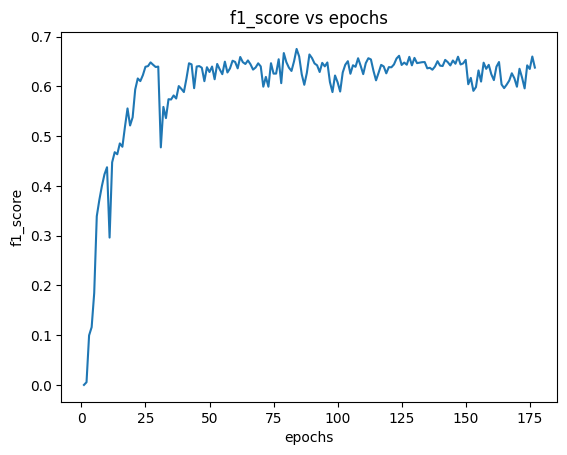

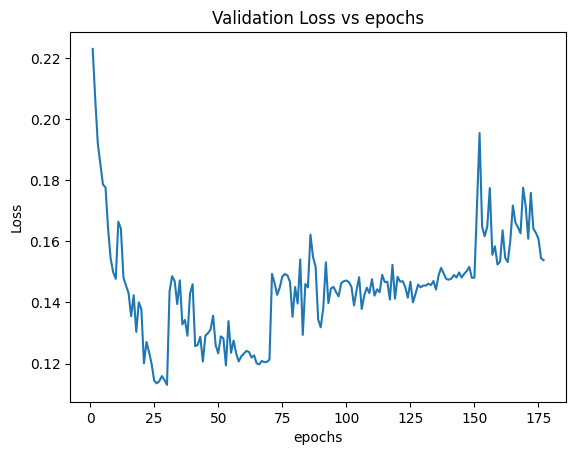

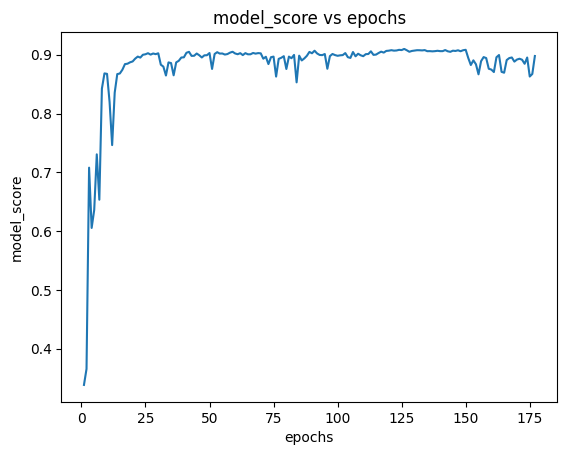

In [8]:
K= len(f1_arr) +1
plt.figure(1)
#plt.plot(sorted(list(set(roc_epochs))), f1_arr)
plt.plot(range(1,K), f1_arr)
plt.xlabel("epochs")
plt.ylabel("f1_score")
plt.title('f1_score vs epochs')

plt.figure(2)
#plt.plot(sorted(list(set(roc_epochs))), loss_arr)
plt.plot(range(1,K), loss_arr)
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.title('Validation Loss vs epochs')

plt.figure(3)
#plt.plot(sorted(list(set(roc_epochs))), f1_arr)
plt.plot(range(1,K), model_arr)
plt.xlabel("epochs")
plt.ylabel("model_score")
plt.title('model_score vs epochs')

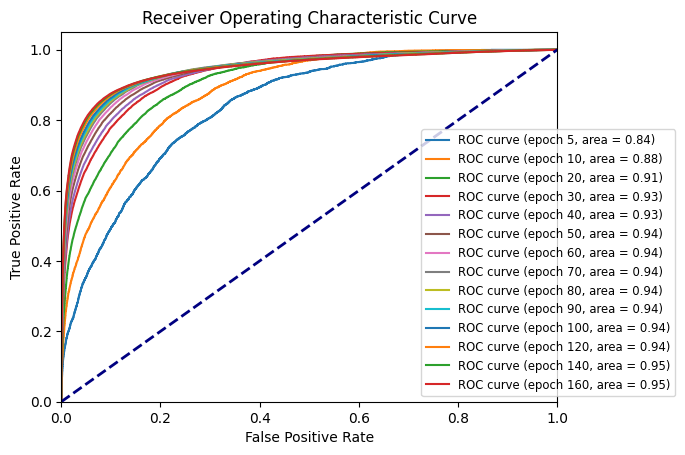

In [9]:
# plot ROC curve
fig2, ax2 = plt.subplots()
for i in range(len(roc_auc)):
    ax2.plot(roc_fpr[i], roc_tpr[i], label=f'ROC curve (epoch {roc_epochs[i]}, area = {roc_auc[i]:.2f})')
ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('Receiver Operating Characteristic Curve')
# Set the properties for the legend
legend = ax2.legend(loc='lower right', bbox_to_anchor=(1.25, 0), fontsize='small', framealpha=0.8)